In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import librosa
import librosa.display
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import IPython.display as ipd
import seaborn as sns

# Dysarthria Data Organization and CSV Generation

- This script processes a dataset of speech recordings related to dysarthria.
- It iterates through a directory structure organized by gender, dysarthria label (Dysarthria/NotDysarthria), session, and microphone type (arrayMic/headMic).
- The script renames all `.wav` files sequentially and creates a Pandas DataFrame containing the file paths, labels, gender, and microphone type.
- Finally, it saves this DataFrame to a CSV file named `dysarthria_data.csv`.
---
# Note:
- The organization of the dataset, including the directory structure containing the `.wav` files, is based on the dataset attached to this notebook. The dataset is arranged in a manner that allows for efficient processing, where each class of data (such as different speech categories or classes) is organized into separate subdirectories. Each `.wav` file within these subdirectories represents a sample corresponding to the class label.

- This structure allows for the dataset to be easily loaded and processed for model training and evaluation, ensuring that each sample is correctly labeled and utilized during training.

In [ ]:
import os
import pandas as pd

def process_dysarthria_data(base_dir):
    data = []
    global_counter = 1

    # Iterate through the gender and dysarthria level folders
    for gender in ['Female', 'Male']:
        for label in ['Dysarthria', 'NotDysarthria']:
            label_dir = os.path.join(base_dir, f"{gender}\\{label}")

            if not os.path.exists(label_dir):
                continue

            # Process session folders
            for session_folder in sorted(os.listdir(label_dir)):
                session_path = os.path.join(label_dir, session_folder)

                if not os.path.isdir(session_path):
                    continue

                # Process microphone folders
                for mic_type in ['wav_arrayMic', 'wav_headMic']:
                    mic_path = os.path.join(session_path, mic_type)

                    if not os.path.exists(mic_path):
                        continue

                    # Process wav files and rename them sequentially
                    wav_files = sorted(os.listdir(mic_path))

                    for wav_file in wav_files:
                        old_path = os.path.join(mic_path, wav_file)

                        if not wav_file.endswith(".wav"):
                            continue

                        # Create new filename
                        new_filename = f"{global_counter:04d}.wav"
                        new_path = os.path.join(mic_path, new_filename)

                        # Rename the file
                        os.rename(old_path, new_path)

                        # Add file details to the dataframe
                        data.append({
                            "path": new_path,
                            "label": label,
                            "gender": gender,
                            "micType": mic_type
                        })

                        global_counter += 1

    # Create dataframe
    df = pd.DataFrame(data)
    return df

# Base directory of your dataset
base_directory = os.getcwd()

# Process the data and create the dataframe
df = process_dysarthria_data(base_directory)

# Save dataframe to a CSV file
df.to_csv("/kaggle/output/torgodataset.csv", index=False)

print("Data processing complete. Dataframe saved to dysarthria_data.csv.")

# Loading and Sampling the Torgo Dataset
- This code snippet uses the Pandas library to load a CSV file named `torgodataset.csv` into a DataFrame and then displays a random sample of 5 rows.

In [3]:
df = pd.read_csv('/kaggle/input/torgodataset-organized/torgodataset-(organized).csv')
df.sample(5)

,gender,micType,path,label
3884,Female,wav_arrayMic,/kaggle/input/torgodataset-organized/Female/No...,0
16400,Male,wav_arrayMic,/kaggle/input/torgodataset-organized/Male/NotD...,0
7600,Male,wav_headMic,/kaggle/input/torgodataset-organized/Male/Dysa...,1
4298,Female,wav_headMic,/kaggle/input/torgodataset-organized/Female/No...,0
4045,Female,wav_arrayMic,/kaggle/input/torgodataset-organized/Female/No...,0


# Examining DataFrame Column Statistics
- This code snippet prints statistics about several columns in the DataFrame, including the distribution of labels, gender, microphone type, and the number of unique file paths.

In [5]:
print(f"{df['label'].value_counts()}\n\nUnique Labels: {df['label'].unique()}\nTotal Unique Labels: {df['label'].nunique()}\n")
print(f"{df['gender'].value_counts()}\n\nUnique Labels: {df['gender'].unique()}\nTotal Unique Labels: {df['gender'].nunique()}\n")
print(f"{df['micType'].value_counts()}\n\nUnique Labels: {df['micType'].unique()}\nTotal Unique Labels: {df['micType'].nunique()}\n")
print(f"Unique Paths/Files: {df['path'].nunique()}\n")

label
0    11456
1     6179
Name: count, dtype: int64

Unique Labels: [1 0]
Total Unique Labels: 2

gender
Male      10566
Female     7069
Name: count, dtype: int64

Unique Labels: ['Female' 'Male']
Total Unique Labels: 2

micType
wav_arrayMic    9417
wav_headMic     8218
Name: count, dtype: int64

Unique Labels: ['wav_arrayMic' 'wav_headMic']
Total Unique Labels: 2

Unique Paths/Files: 17635



# Fetching Random Audio Samples

In [6]:
male_dysarthric = df[(df['gender']=='Male') & (df['label']==1)].sample(1)
female_dysarthric = df[(df['gender']=='Female') & (df['label']==1)].sample(1)
male_ndysarthric = df[(df['gender']=='Male') & (df['label']==0)].sample(1)
female_ndysarthric = df[(df['gender']=='Female') & (df['label']==0)].sample(1)

- Male with Dysarthria

In [7]:
ipd.Audio(male_dysarthric.iloc[0].path)

- Female with Dysarthria

In [8]:
ipd.Audio(female_dysarthric.iloc[0].path)

- Male with NotDysarthria

In [9]:
ipd.Audio(male_ndysarthric.iloc[0].path)

- Female with NotDysarthria

In [10]:
ipd.Audio(female_ndysarthric.iloc[0].path)

# Basic Viz of Torgo Dataset

- Wave Plot

In [11]:
def show_waveplot(audio_path,label,gender):
    try:
        # Load the audio file
        x, sr = librosa.load(audio_path)

        # Create the waveplot
        plt.figure(figsize=(20, 6))
        librosa.display.waveshow(x, sr=sr)

        # Set the title with the label and gender
        plt.title(f"Waveplot: Class: {label}, Gender: {gender}")

        # Display the plot
        plt.show()
    except Exception as e:
        print(f"Error loading or displaying the audio file: {e}")

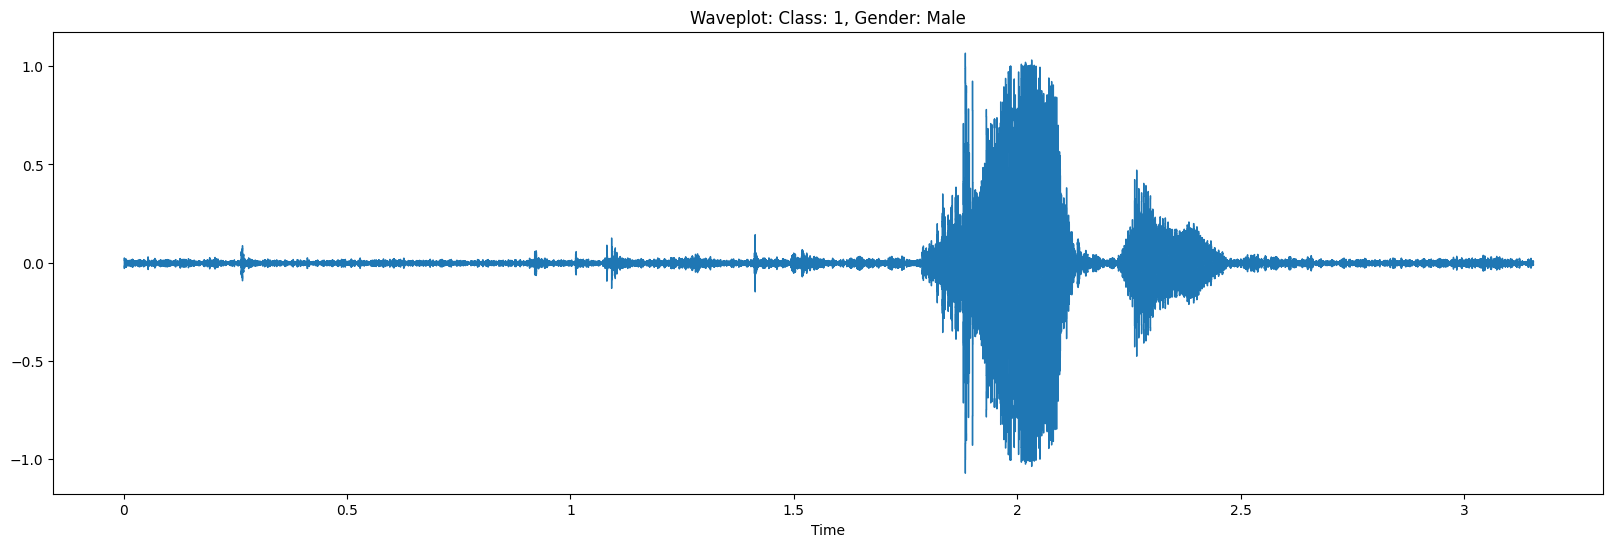

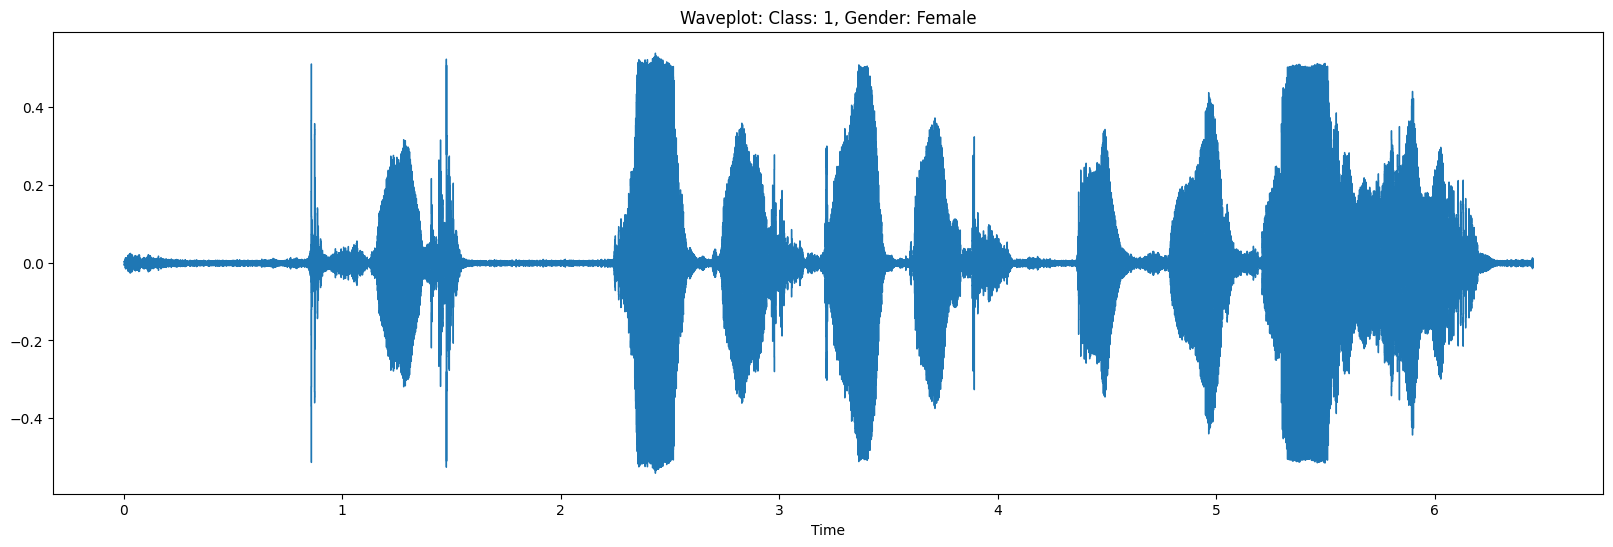

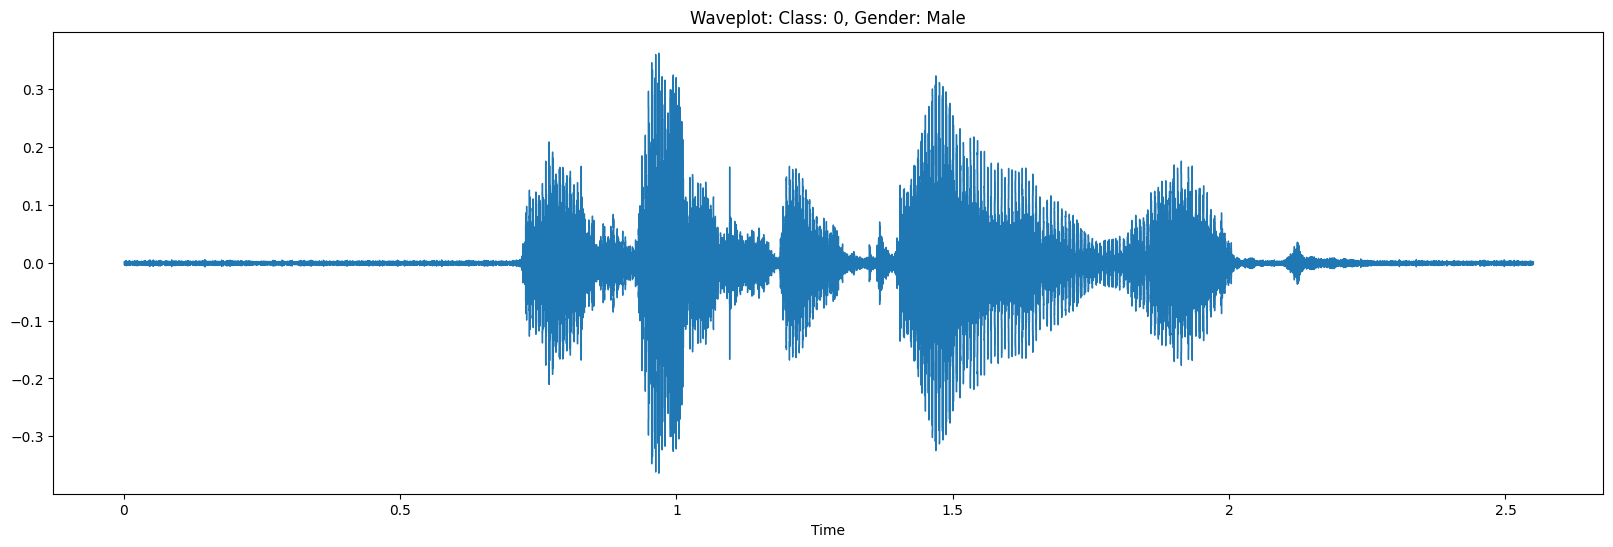

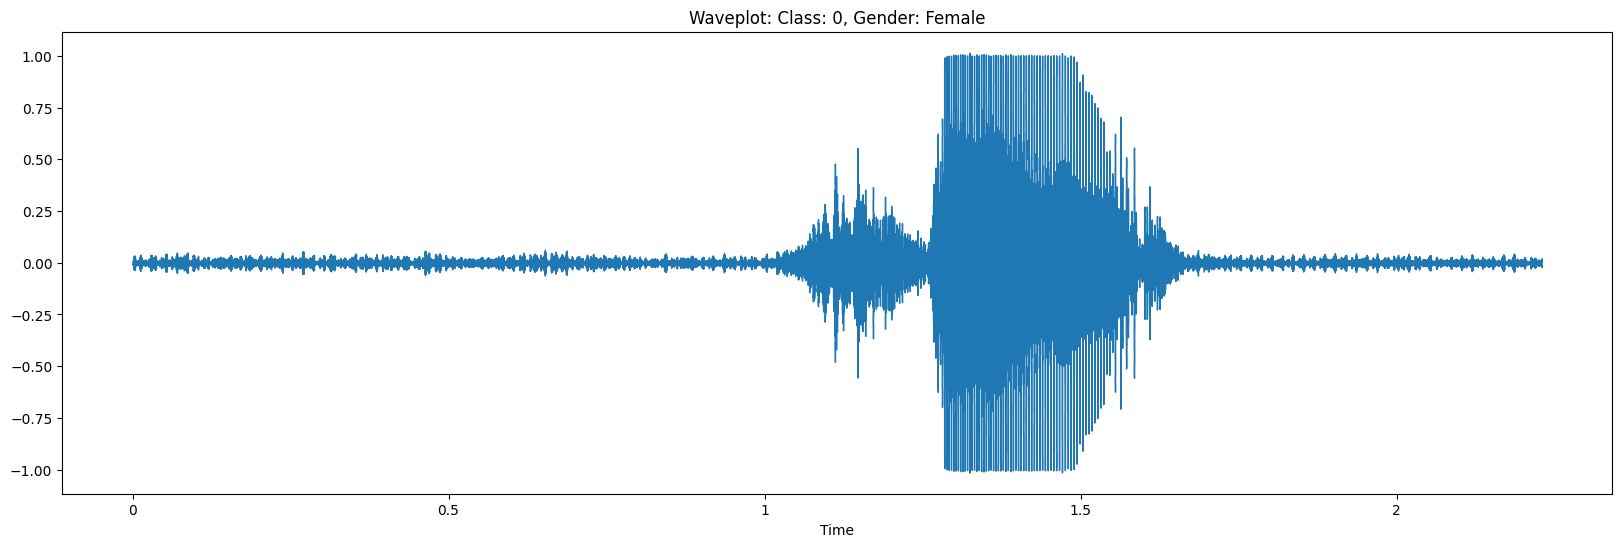

In [12]:
show_waveplot(male_dysarthric.iloc[0].path, male_dysarthric.iloc[0].label, male_dysarthric.iloc[0].gender)
show_waveplot(female_dysarthric.iloc[0].path, female_dysarthric.iloc[0].label, female_dysarthric.iloc[0].gender)
show_waveplot(male_ndysarthric.iloc[0].path, male_ndysarthric.iloc[0].label, male_ndysarthric.iloc[0].gender)
show_waveplot(female_ndysarthric.iloc[0].path, female_ndysarthric.iloc[0].label, female_ndysarthric.iloc[0].gender)

- Spectrogram

In [14]:
def show_spectrogram(audio_path,label,gender):
    x , sr = librosa.load(audio_path)
    X = librosa.stft(x)
    Xdb = librosa.amplitude_to_db(abs(X))
    plt.figure(figsize=(20,6))
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz',cmap='plasma')
    plt.colorbar()
    plt.title(f"Spectrogram of Class: {label}, Gender: {gender}")

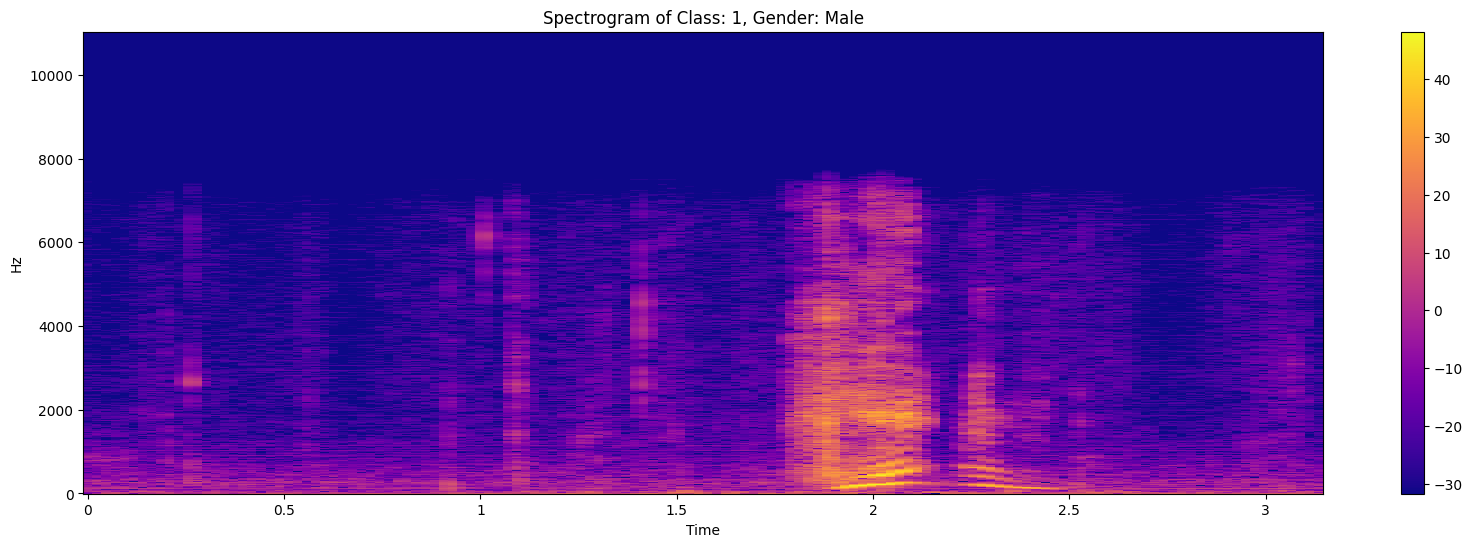

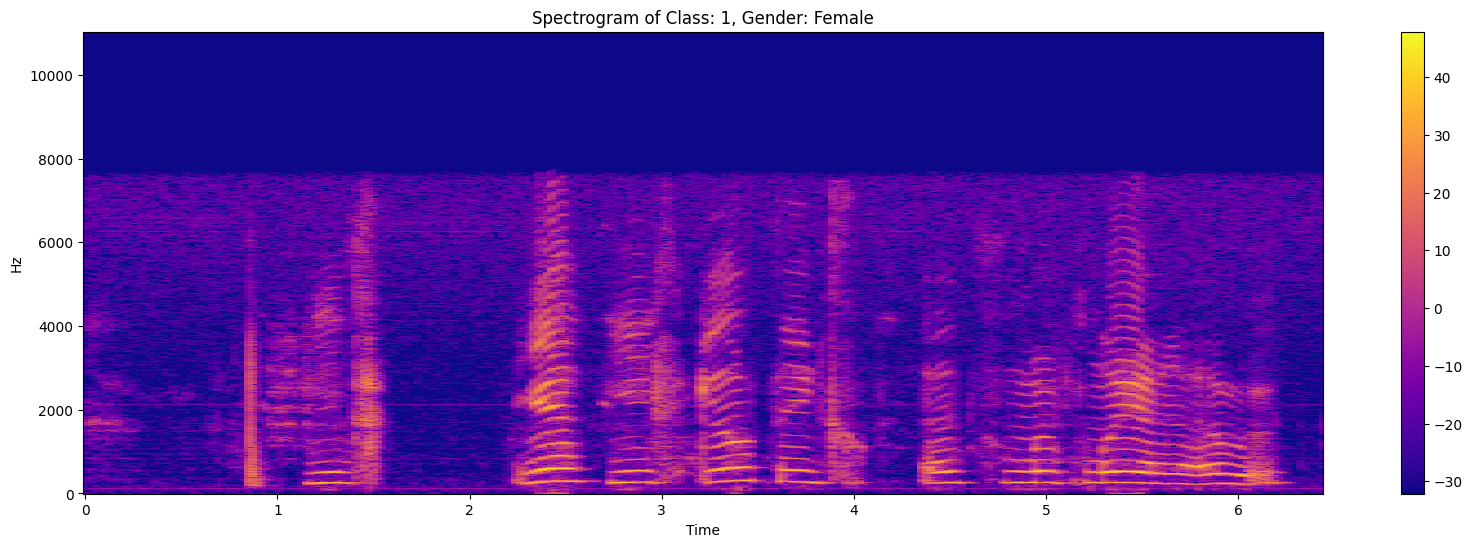

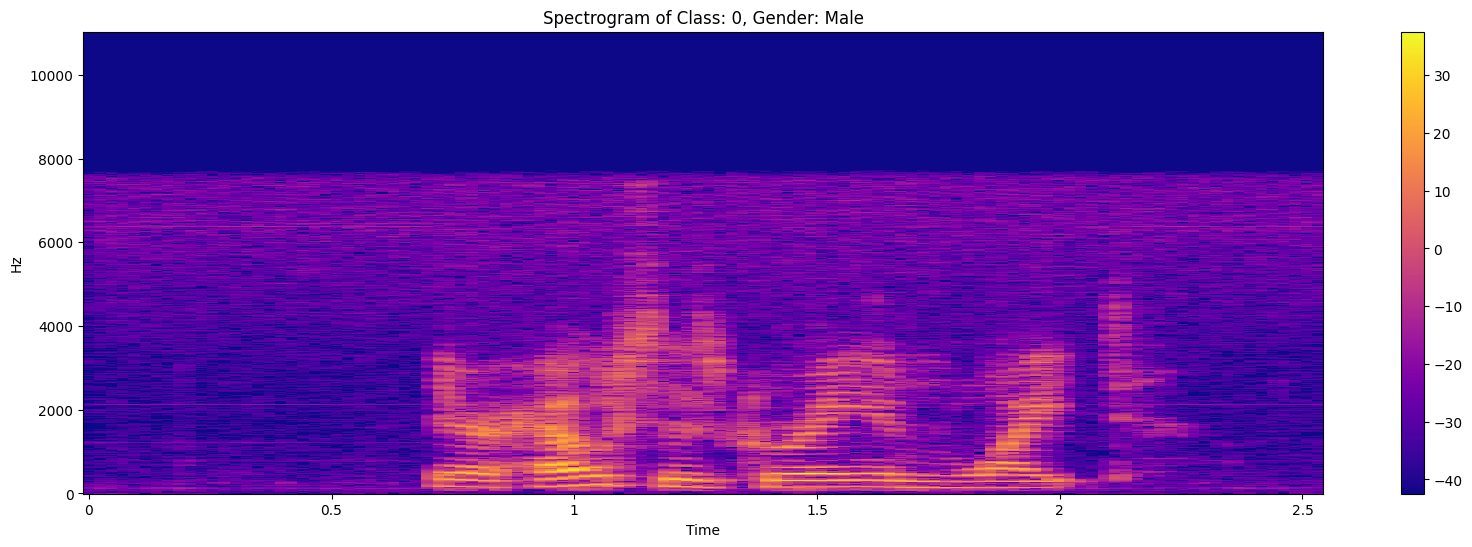

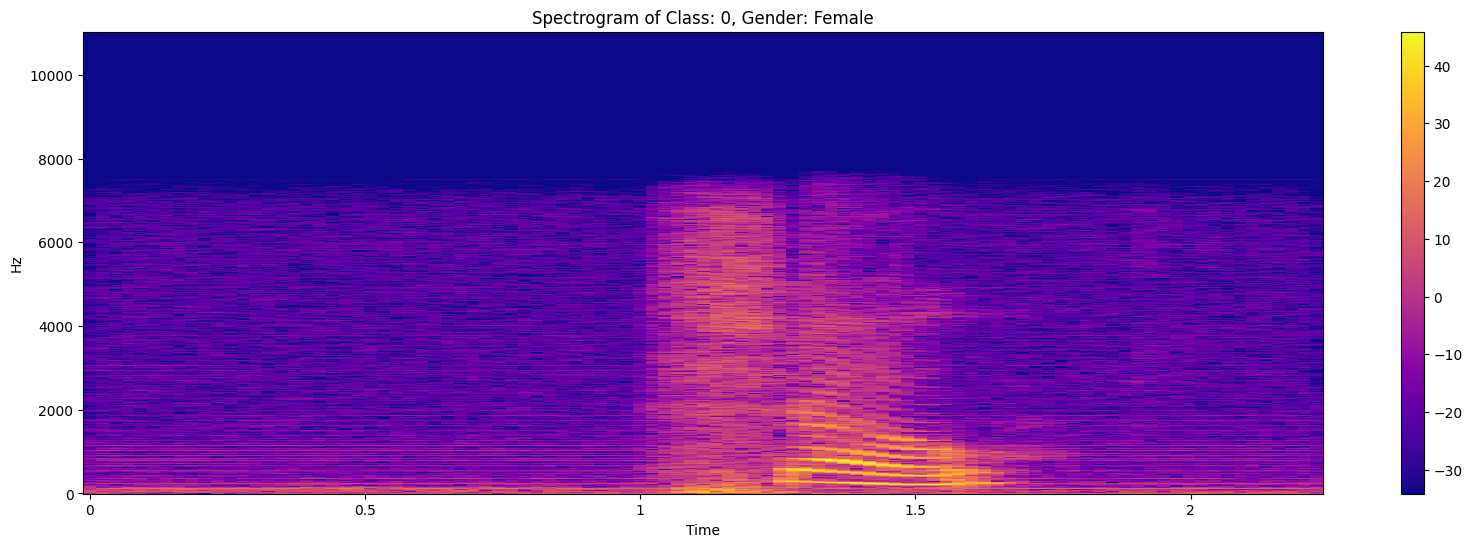

In [15]:
show_spectrogram(male_dysarthric.iloc[0].path, male_dysarthric.iloc[0].label, male_dysarthric.iloc[0].gender)
show_spectrogram(female_dysarthric.iloc[0].path, female_dysarthric.iloc[0].label, female_dysarthric.iloc[0].gender)
show_spectrogram(male_ndysarthric.iloc[0].path, male_ndysarthric.iloc[0].label, male_ndysarthric.iloc[0].gender)
show_spectrogram(female_ndysarthric.iloc[0].path, female_ndysarthric.iloc[0].label, female_ndysarthric.iloc[0].gender)

- Spectral Roll-off Plot

In [16]:
def normalize(arr):
    return (arr - np.min(arr)) / (np.max(arr) - np.min(arr)) # Normalize an array to the range [0, 1]

def show_spectral_rolloff(audio_path, label, gender):
    plt.figure(figsize=(20, 6))
    plt.title(f'Spectral Rolloff of Class: {label}, Gender: {gender}')

    x, sr = librosa.load(audio_path)

    # Compute spectral rolloff
    spectral_rolloff = librosa.feature.spectral_rolloff(y=x, sr=sr, roll_percent=0.01)[0]

    # Convert frames to time
    frames = range(len(spectral_rolloff))
    t = librosa.frames_to_time(frames, sr=sr)

    librosa.display.waveshow(x, sr=sr, alpha=0.4, label='Waveform')

    plt.plot(t, normalize(spectral_rolloff), color='r', label='Spectral Rolloff (normalized)')

    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude / Rolloff')
    plt.legend()
    plt.show()


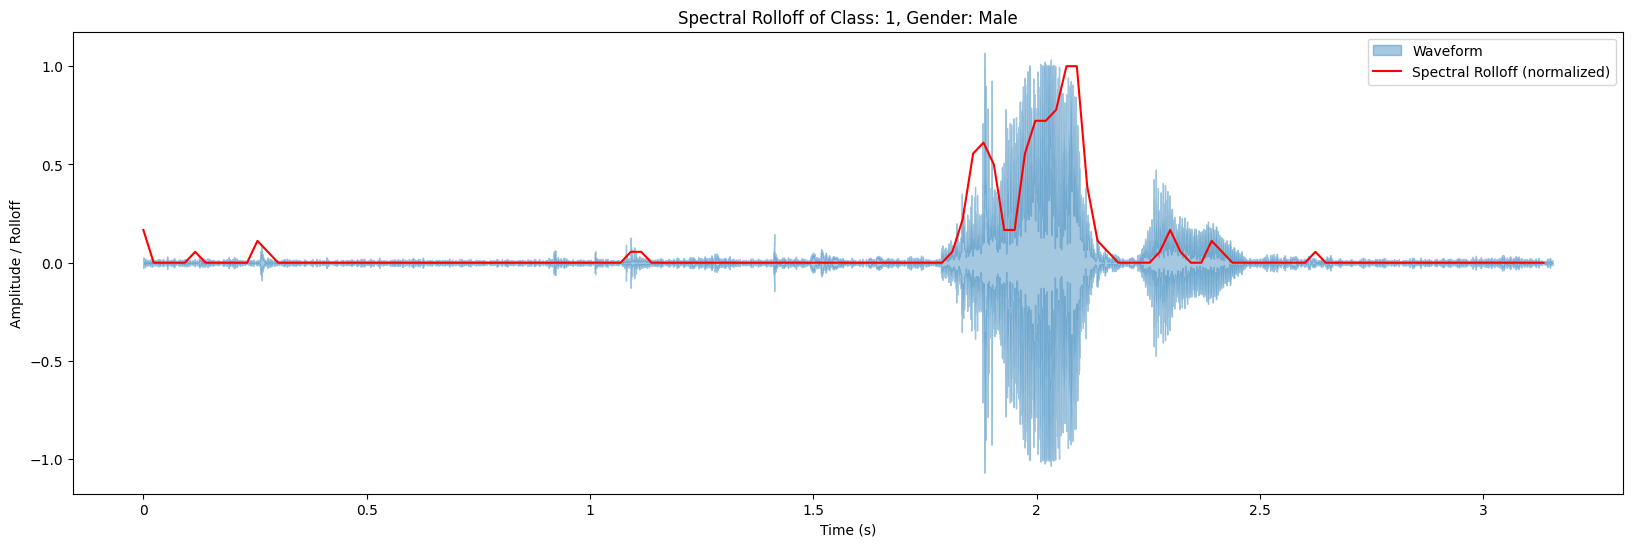

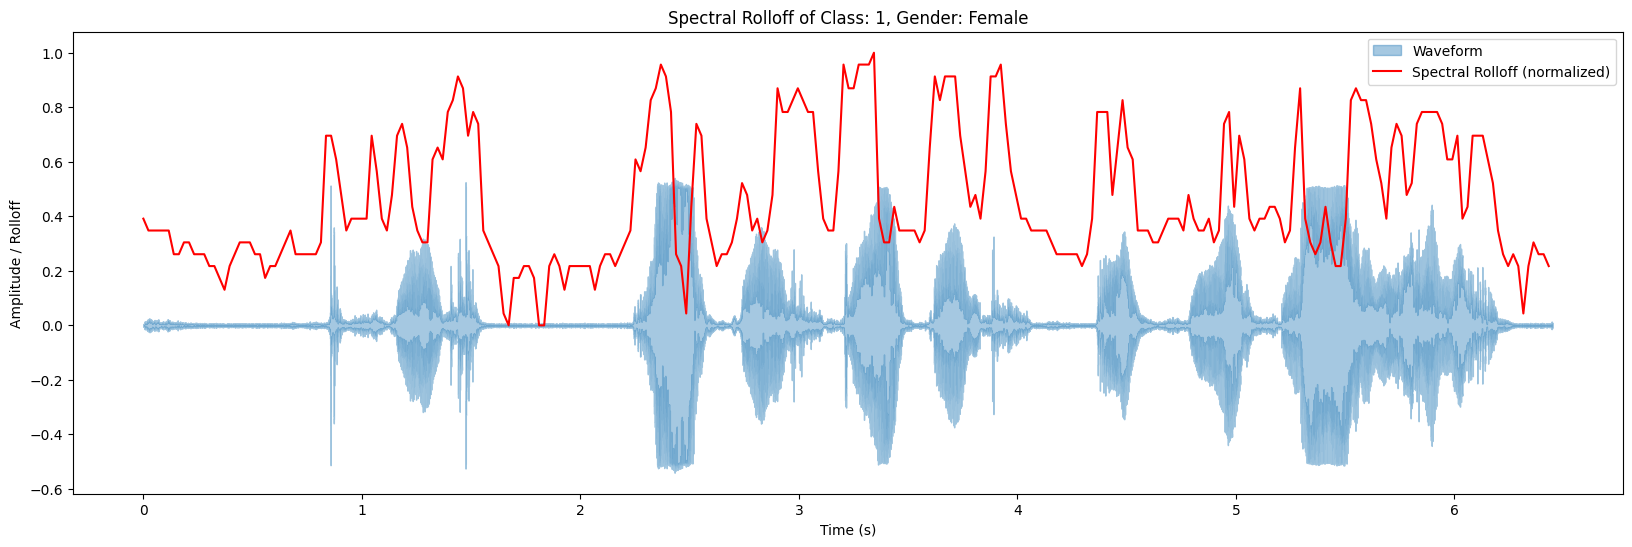

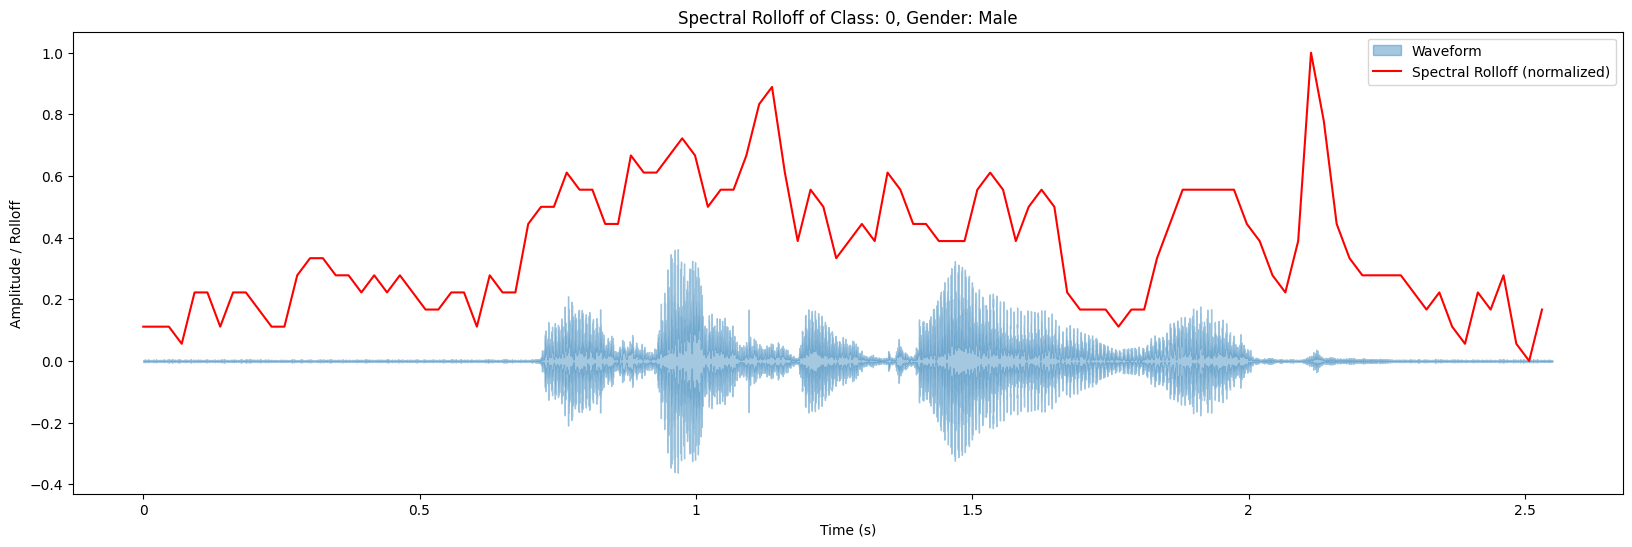

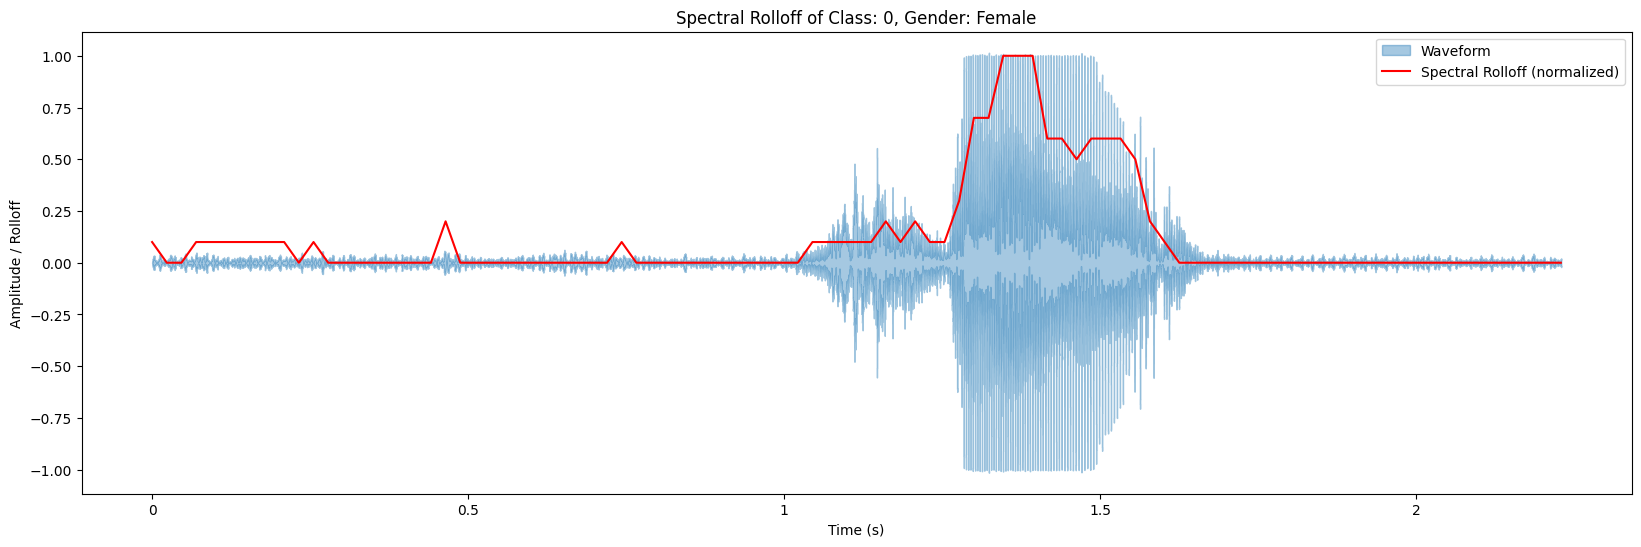

In [17]:
show_spectral_rolloff(male_dysarthric.iloc[0].path, male_dysarthric.iloc[0].label, male_dysarthric.iloc[0].gender)
show_spectral_rolloff(female_dysarthric.iloc[0].path, female_dysarthric.iloc[0].label, female_dysarthric.iloc[0].gender)
show_spectral_rolloff(male_ndysarthric.iloc[0].path, male_ndysarthric.iloc[0].label, male_ndysarthric.iloc[0].gender)
show_spectral_rolloff(female_ndysarthric.iloc[0].path, female_ndysarthric.iloc[0].label, female_ndysarthric.iloc[0].gender)

- MFCCs Plot

In [18]:
def show_mfccs(audio_path,label,gender):
    plt.figure(figsize=(20, 6))
    plt.title(f'MFCC of Class: {label}, Gender: {gender}')
    x , sr = librosa.load(audio_path)
    mfccs = librosa.feature.mfcc(y=x, sr=sr)
    librosa.display.specshow(mfccs, sr=sr, x_axis='time',cmap='plasma')
    plt.show()

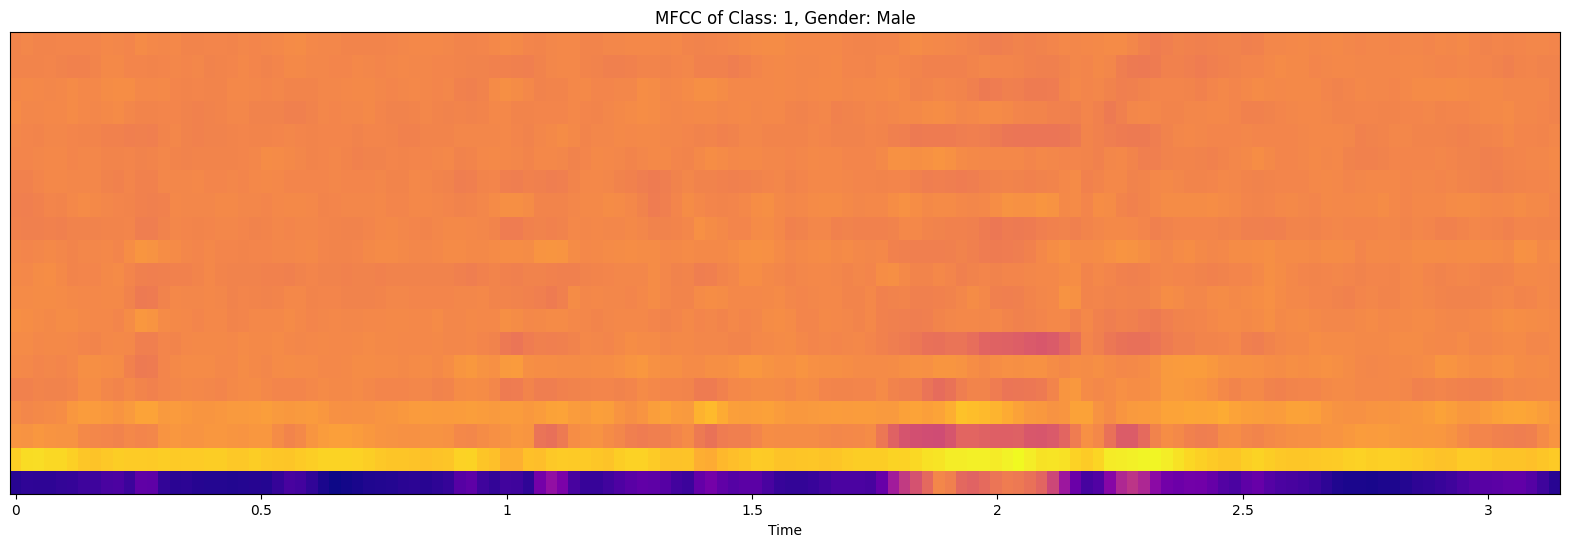

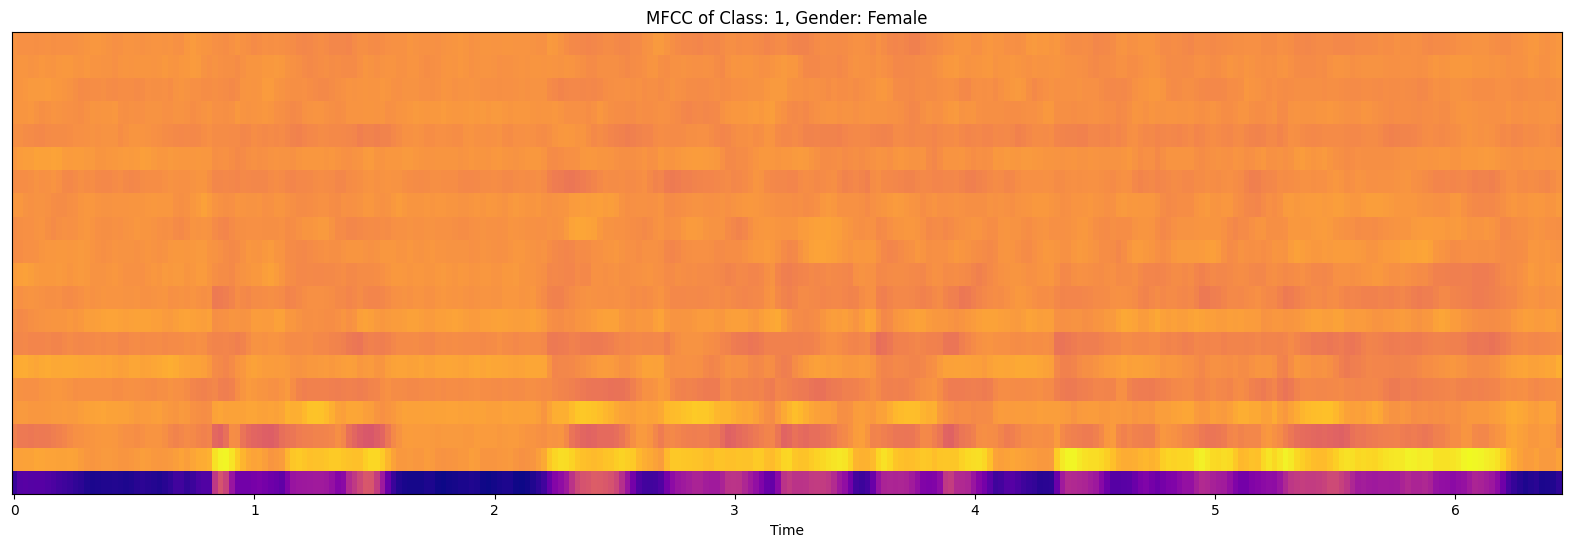

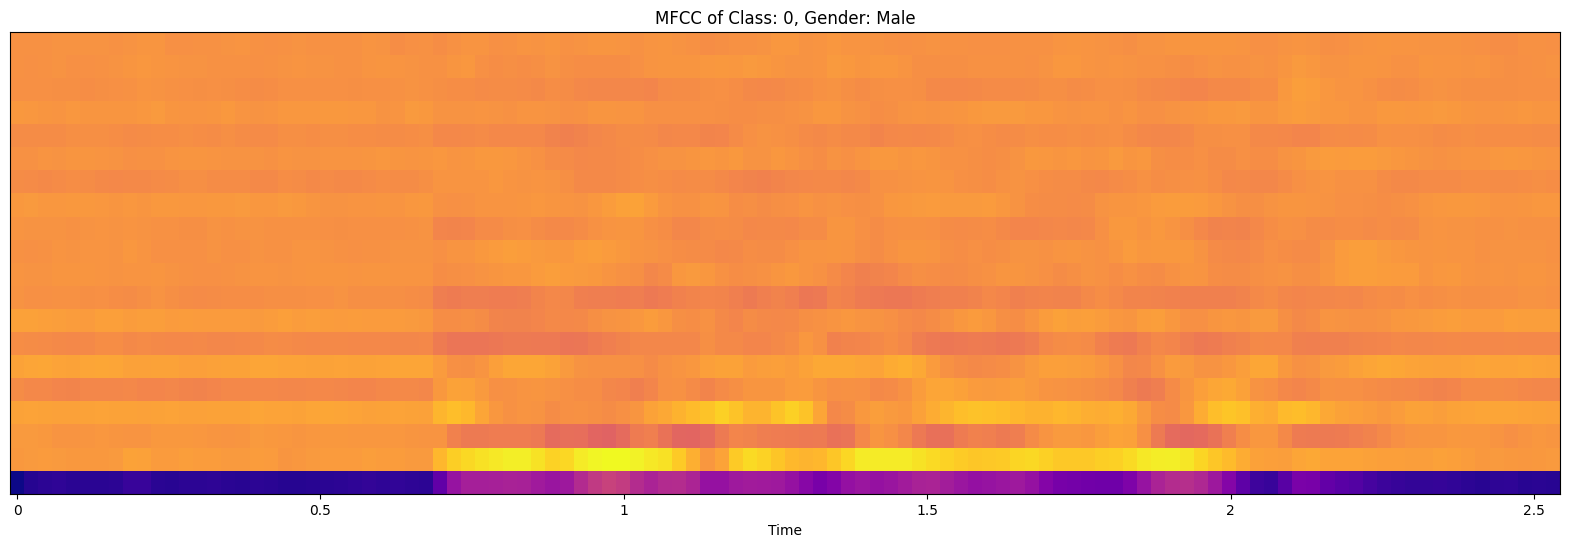

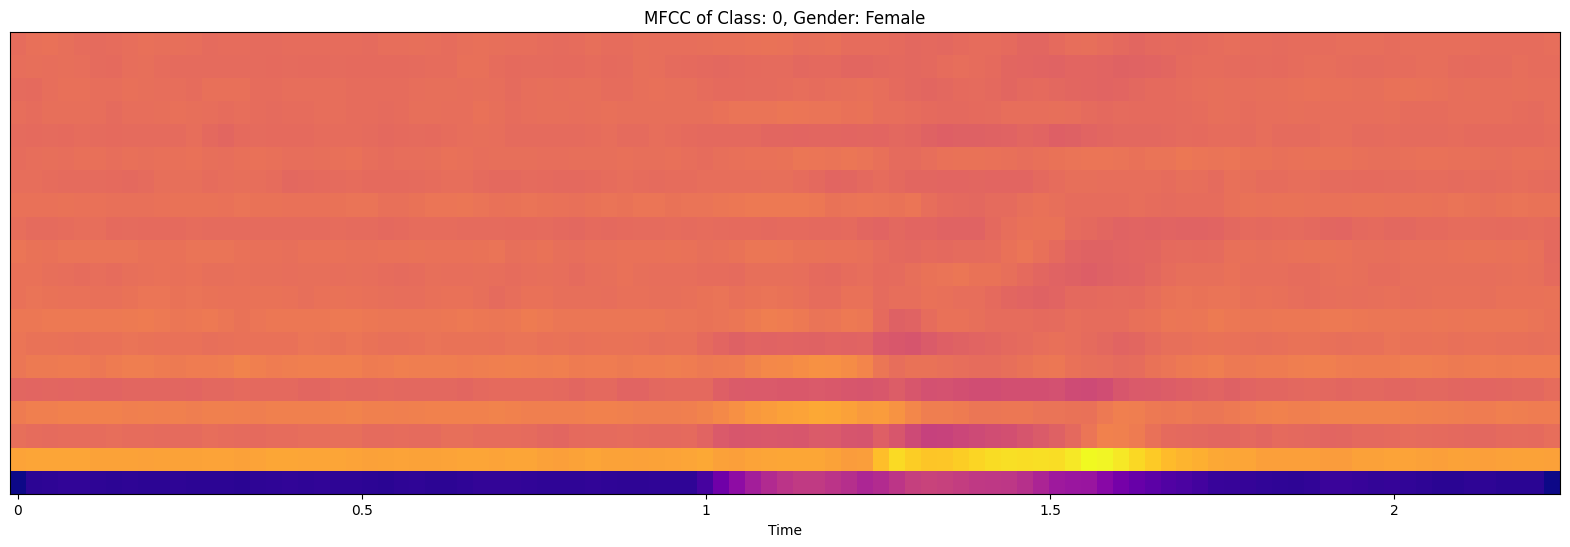

In [19]:
show_mfccs(male_dysarthric.iloc[0].path, male_dysarthric.iloc[0].label, male_dysarthric.iloc[0].gender)
show_mfccs(female_dysarthric.iloc[0].path, female_dysarthric.iloc[0].label, female_dysarthric.iloc[0].gender)
show_mfccs(male_ndysarthric.iloc[0].path, male_ndysarthric.iloc[0].label, male_ndysarthric.iloc[0].gender)
show_mfccs(female_ndysarthric.iloc[0].path, female_ndysarthric.iloc[0].label, female_ndysarthric.iloc[0].gender)

- Melspectogram Plot

In [20]:
def show_melspectro(audio_path,label,gender):
    plt.figure(figsize=(20, 6))
    plt.title(f'Mel Spectro of Class: {label}, Gender: {gender}')
    x , sr = librosa.load(audio_path)
    melspectro = librosa.feature.melspectrogram(y=x, sr=sr)
    librosa.display.specshow(melspectro, sr=sr, x_axis='time',cmap='plasma')
    plt.show()

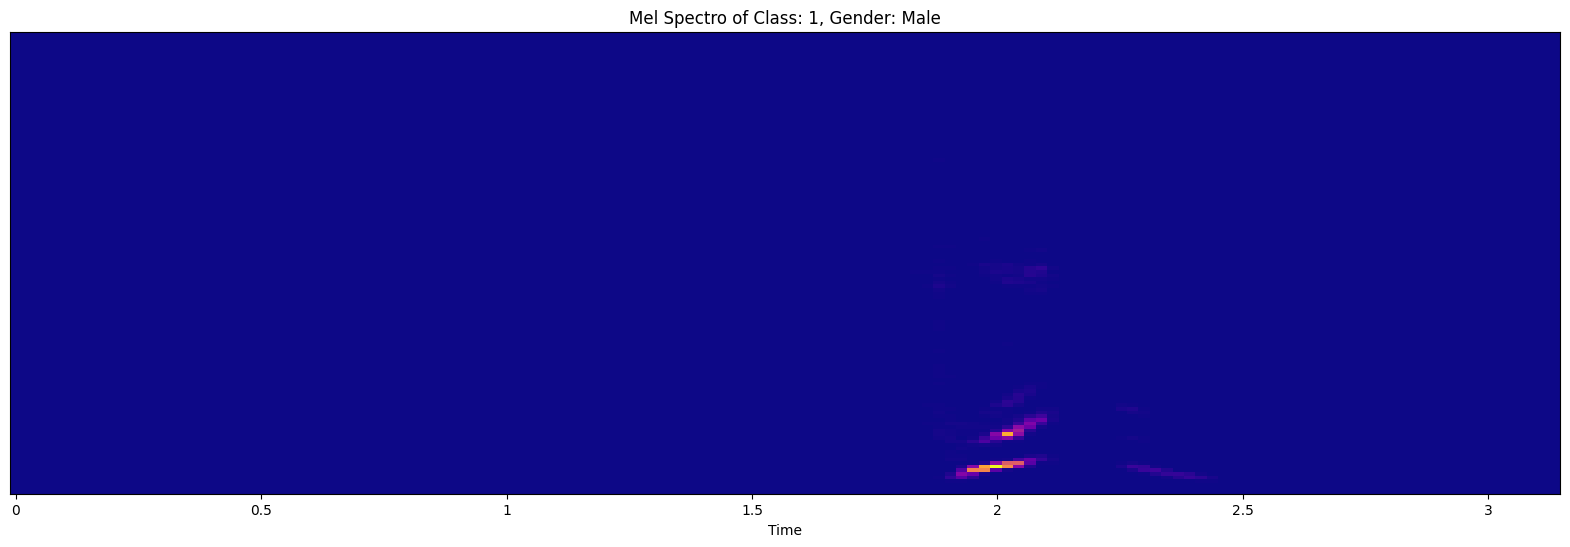

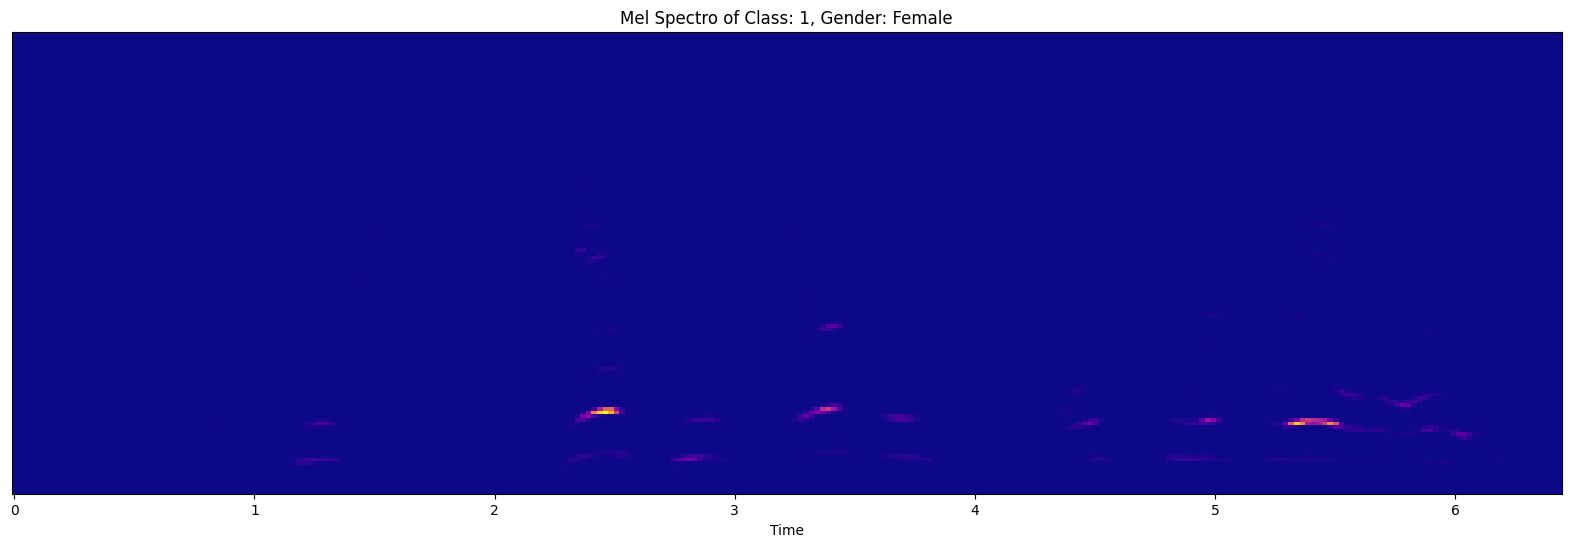

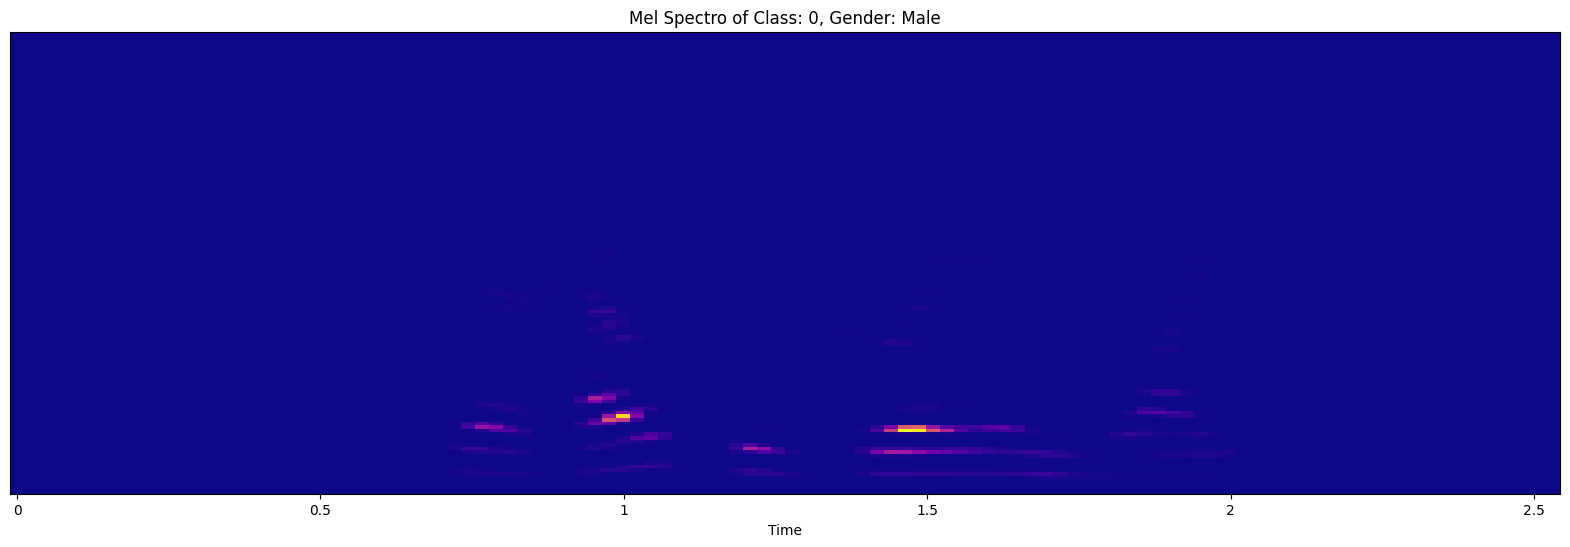

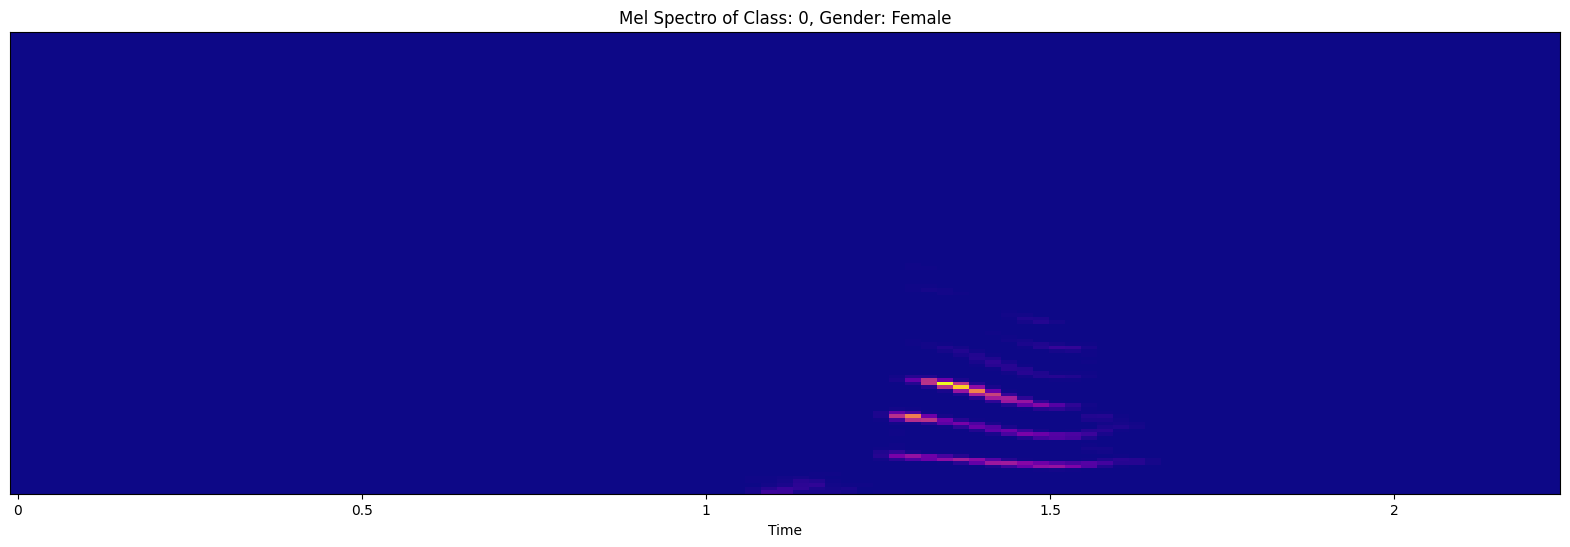

In [21]:
show_melspectro(male_dysarthric.iloc[0].path, male_dysarthric.iloc[0].label, male_dysarthric.iloc[0].gender)
show_melspectro(female_dysarthric.iloc[0].path, female_dysarthric.iloc[0].label, female_dysarthric.iloc[0].gender)
show_melspectro(male_ndysarthric.iloc[0].path, male_ndysarthric.iloc[0].label, male_ndysarthric.iloc[0].gender)
show_melspectro(female_ndysarthric.iloc[0].path, female_ndysarthric.iloc[0].label, female_ndysarthric.iloc[0].gender)

- Log-Mel Spectogram

In [22]:
def plot_log_mel_spectrogram(audio_path, label, gender, sr=16000, n_mels=128):

    x, sampling_rate = librosa.load(audio_path, sr=sr)
    # Compute the Mel spectrogram
    mel_spec = librosa.feature.melspectrogram(y=x, sr=sampling_rate, n_mels=n_mels)
    # Convert to Log scale (dB)
    log_mel_spec = librosa.power_to_db(mel_spec, ref=np.max)

    plt.figure(figsize=(20, 6))
    librosa.display.specshow(log_mel_spec, sr=sampling_rate, x_axis='time', y_axis='mel', cmap='magma')
    plt.colorbar(format='%+2.0f dB')
    plt.title(f"Log-Mel Spectrogram of Class: {label}, Gender: {gender}")
    plt.tight_layout()
    plt.show()

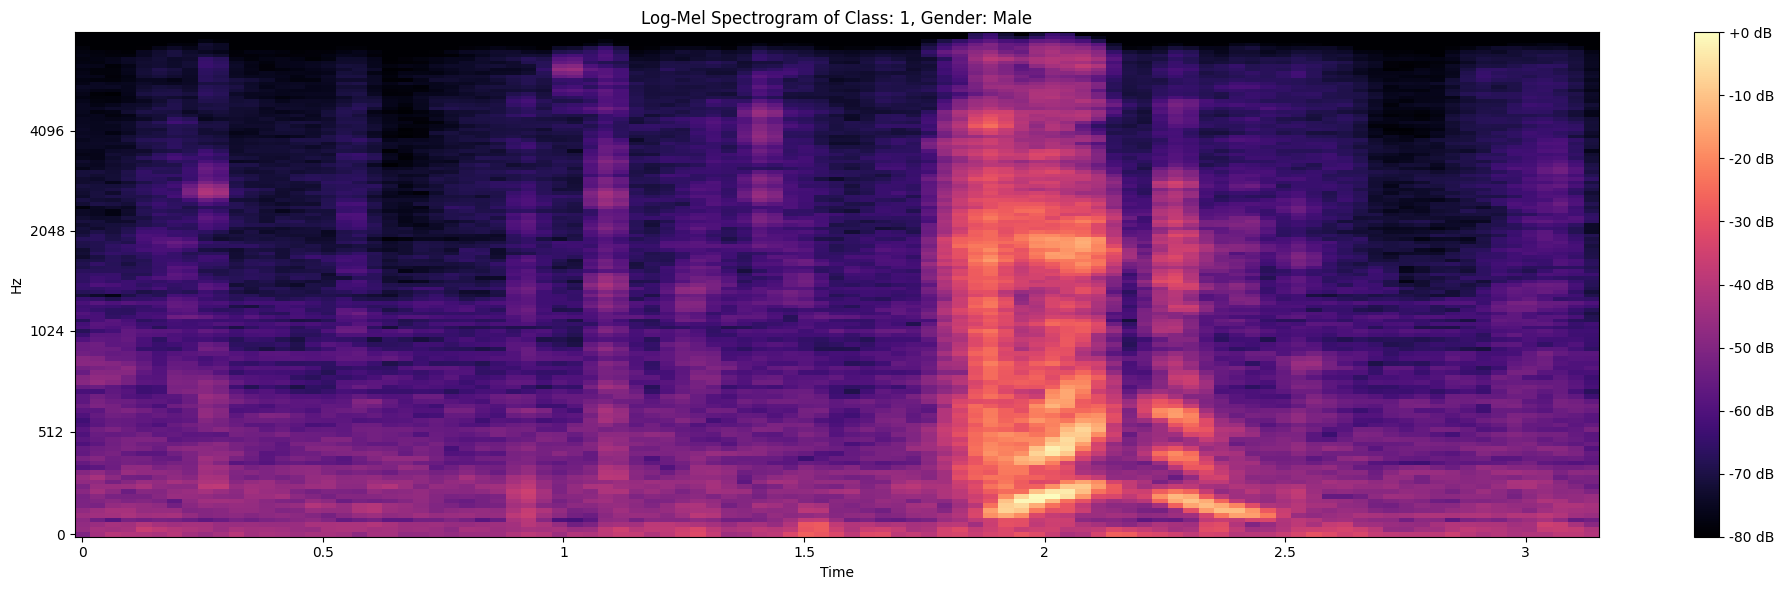

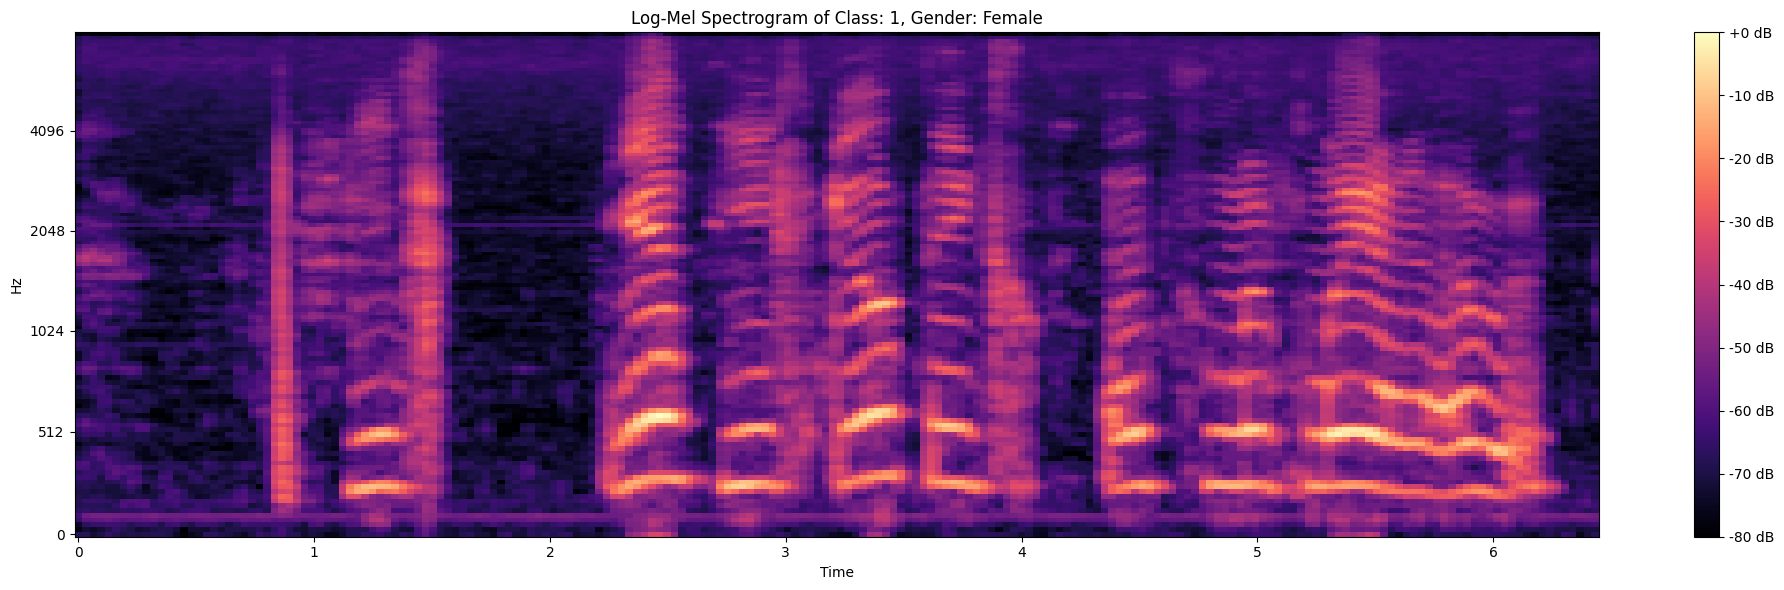

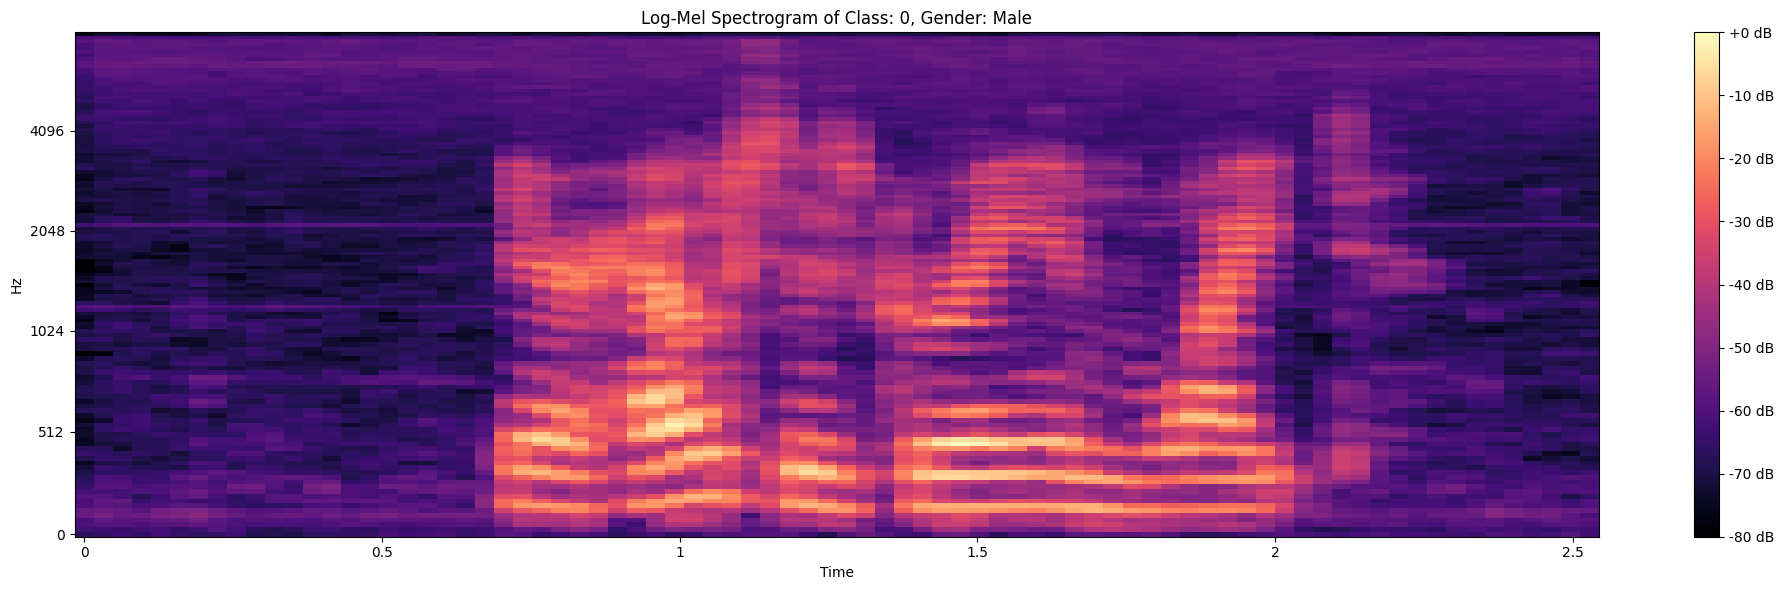

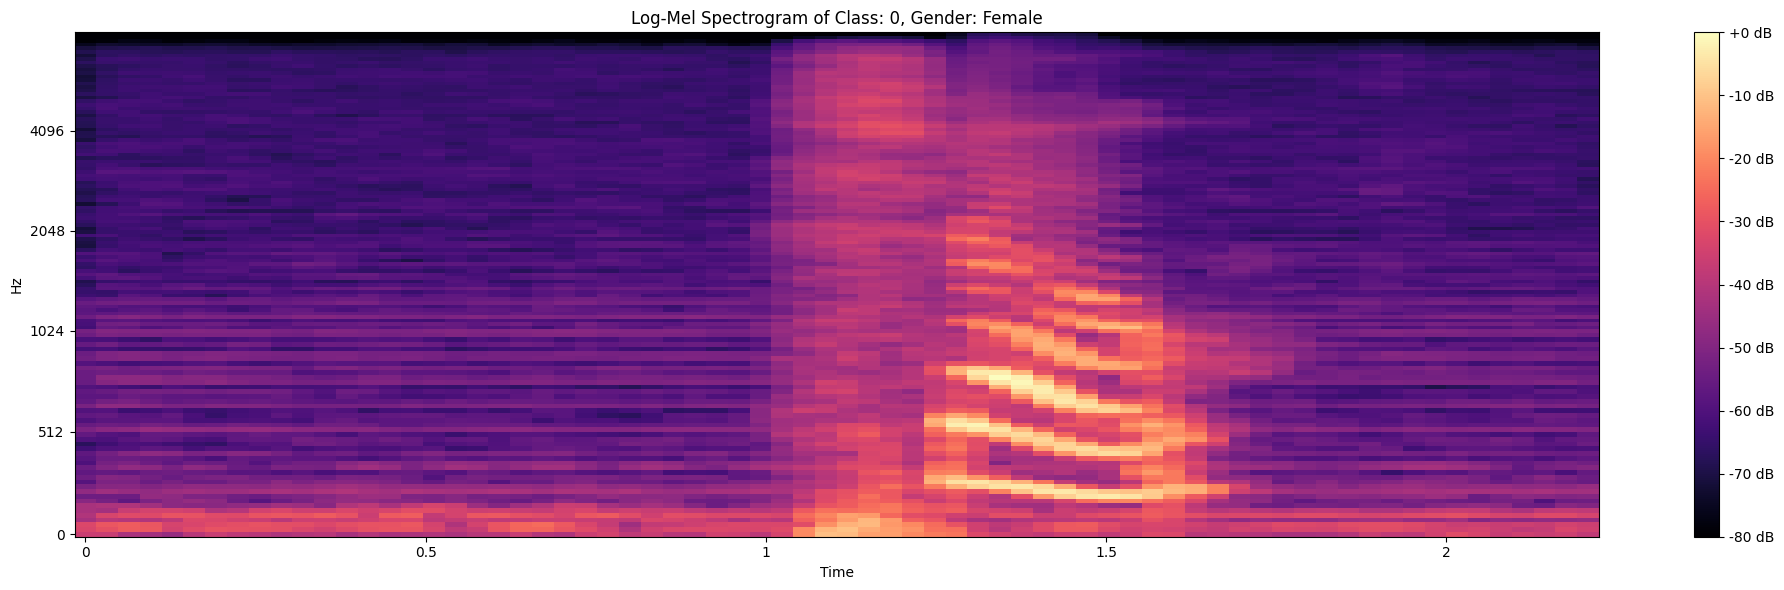

In [23]:
plot_log_mel_spectrogram(male_dysarthric.iloc[0].path, male_dysarthric.iloc[0].label, male_dysarthric.iloc[0].gender)
plot_log_mel_spectrogram(female_dysarthric.iloc[0].path, female_dysarthric.iloc[0].label, female_dysarthric.iloc[0].gender)
plot_log_mel_spectrogram(male_ndysarthric.iloc[0].path, male_ndysarthric.iloc[0].label, male_ndysarthric.iloc[0].gender)
plot_log_mel_spectrogram(female_ndysarthric.iloc[0].path, female_ndysarthric.iloc[0].label, female_ndysarthric.iloc[0].gender)

# Generating Log-Mel Spectrogram Images from Audio Data using Librosa

- This code converts audio files into log-Mel spectrogram images for use in deep learning task related to dysarthria classification.

## 1. Purpose

- The code's primary objective is to transform audio data into a visual format (spectrograms) that can be easily processed by deep learning models. Spectrograms represent the frequency content of an audio signal over time, capturing crucial features like frequency changes, harmonics, and temporal patterns. These features are valuable for analyzing speech patterns, especially in cases like dysarthria, where subtle differences in speech might be present.
---
## 2. Code Breakdown

- The code consists of several key components:

### 2.1 Imports

- The code begins by importing necessary libraries:

*   `os`: For operating system interactions (file paths, directories).
*   `librosa`: A powerful Python library for audio and music analysis.
*   `librosa.display`: For visualizing audio data, including spectrograms.
*   `numpy`: For numerical computations.
*   `matplotlib.pyplot`: For plotting and saving images.
*   `gc`: For garbage collection (memory management).
*   `tqdm`: For displaying progress bars during processing.

### 2.2 `create_directory(path)`

- This function ensures that the specified directory exists. If the directory does not exist, it is created. This prevents errors when the code attempts to save images to non-existent locations.

### 2.3 Directory Setup

- The code defines variables for the output folders:

*   `data_folder`: The main output folder.
*   `class0_folder`: Subfolder for audio files labeled as class 0 (e.g., "NotDysarthria").
*   `class1_folder`: Subfolder for audio files labeled as class 1 (e.g., "Dysarthria").

- The `create_directory` function is used to create these folders before processing begins.

### 2.4 `save_logmel_spectrogram_librosa(audio_path, output_path)`

- This is the core function for generating and saving spectrograms:

1.  **Audio Loading:** `librosa.load(audio_path, sr=16000)` loads the audio file. `sr=16000` sets the sampling rate to 16kHz, a common standard for speech processing.

2.  **Mel Spectrogram Computation:** `librosa.feature.melspectrogram(...)` calculates the Mel spectrogram. Key parameters include:
    *   `y`: The audio waveform.
    *   `sr`: The sampling rate.
    *   `n_mels=128`: The number of Mel frequency bands (128 is a common value).
    *   `n_fft=2048`: The Fast Fourier Transform (FFT) window size.
    *   `hop_length=512`: The hop length (the number of samples between successive FFT windows).

3.  **Logarithmic Scaling:** `librosa.power_to_db(mel_spec, ref=np.max)` converts the Mel spectrogram to the decibel (dB) scale. This logarithmic scaling is crucial for visualization and processing, as it better represents the perceived loudness of frequencies.

4.  **Image Saving:** The code uses `librosa.display.specshow` to display the spectrogram and `matplotlib.pyplot.savefig` to save it as a JPG image. `plt.close()` is essential for releasing memory used by Matplotlib.

5.  **Error Handling:** A `try...except` block handles potential errors during audio loading or processing.

### 2.5 `global_counters`

- This dictionary stores counters for each class (0 and 1). These counters are used to generate unique filenames for the spectrogram images.

### 2.6 `process_batch(df, start_idx, end_idx)`

- This function processes the DataFrame in batches for memory efficiency:

1.  **Batch Iteration:** It iterates through a slice of the DataFrame using `df.iloc[start_idx:end_idx]`.

2.  **Data Extraction:** For each row, it extracts the audio file path and label.

3.  **Output Folder Selection:** It selects the appropriate output folder (`class0_folder` or `class1_folder`) based on the label.

4.  **Filename Generation:** It increments the corresponding counter in `global_counters` and creates a unique filename for the spectrogram.

5.  **Spectrogram Generation and Saving:** It calls `save_logmel_spectrogram_librosa` to generate and save the spectrogram.

6.  **Memory Management:** `gc.collect()` is called after processing each file to release memory.

7.  **Progress Tracking:** `tqdm` provides a progress bar to monitor the batch processing.
---
## 3. Why Spectrograms?

- Spectrograms are powerful tools for audio analysis because they provide a visual representation of how the frequency content of an audio signal changes over time. They capture important acoustic features that are useful for various tasks, including speech recognition, music analysis, and audio classification. In the context of dysarthria, spectrograms can reveal subtle variations in speech patterns that might be difficult to perceive by ear.

In [5]:
import os
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import gc
from tqdm import tqdm

# Function to create directory if it doesn't exist
def create_directory(path):
    if not os.path.exists(path):
        os.makedirs(path)

# Shared variables
data_folder = 'kaggle/working/data'
class0_folder = os.path.join(data_folder, '0')
class1_folder = os.path.join(data_folder, '1')

# Create directories once before processing
create_directory(data_folder)
create_directory(class0_folder)
create_directory(class1_folder)

# Function to save log-mel spectrogram as an image using Librosa
def save_logmel_spectrogram_librosa(audio_path, output_path):
    try:
        # Load audio using librosa
        waveform, sample_rate = librosa.load(audio_path, sr=16000)  # Ensure sampling rate is 16000

        # Compute mel spectrogram
        mel_spec = librosa.feature.melspectrogram(
            y=waveform, sr=16000, n_mels=128, n_fft=2048, hop_length=512
        )

        # Convert to log scale (similar to power_to_db)
        log_mel_spec = librosa.power_to_db(mel_spec, ref=np.max)

        # Save spectrogram as an image
        plt.figure(figsize=(10, 5), dpi=100)
        plt.axis('off')
        librosa.display.specshow(
            log_mel_spec, sr=16000, hop_length=512, x_axis='time', y_axis='mel', cmap='viridis'
        )
        plt.savefig(output_path, bbox_inches='tight', pad_inches=0)
        plt.close()  # Close the figure to free memory

    except Exception as e:
        print(f"\nAudio {audio_path.split('/')[-1]} cannot be converted")

# Global counters for labels
global_counters = {0: 0, 1: 0}  # Start counters for each label at 0

# Function to process a range of rows in the DataFrame
def process_batch(df, start_idx, end_idx):
    global global_counters  # Use global counters for independent tracking
    print(f"Processing batch: {start_idx} to {end_idx} on CPU using Librosa")

    for idx, row in tqdm(df.iloc[start_idx:end_idx].iterrows(), total=end_idx - start_idx):
        audio_path = row['path']
        label = int(row['label'])

        # Determine output folder based on label
        output_folder = class0_folder if label == 0 else class1_folder

        # Increment the label-specific counter and create the filename
        global_counters[label] += 1
        output_filename = f"{global_counters[label]:05d}.jpg"
        output_path = os.path.join(output_folder, output_filename)

        # Save the spectrogram
        save_logmel_spectrogram_librosa(audio_path, output_path)

        # Clear memory after each row
        gc.collect()

    print(f"Batch {start_idx}-{end_idx} completed!")

# Batch 1 (0-4000)

In [5]:
print(global_counters)

{0: 0, 1: 0}


In [6]:
process_batch(df, 0, 4000)  # First batch

Processing batch: 0 to 4000 on CPU using Librosa


  5%|▌         | 200/4000 [01:33<29:10,  2.17it/s] <ipython-input-4-f698a7a61469>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  waveform, sample_rate = librosa.load(audio_path, sr=16000)  # Ensure sampling rate is 16000
/usr/local/lib/python3.10/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
  5%|▌         | 201/4000 [01:33<26:34,  2.38it/s]


Audio 0201.wav cannot be converted

Audio 0202.wav cannot be converted


 66%|██████▌   | 2646/4000 [52:26<45:32,  2.02s/it] /usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=0
  warnings.warn(
100%|██████████| 4000/4000 [1:49:19<00:00,  1.64s/it]

Batch 0-4000 completed!


In [7]:
import shutil
shutil.make_archive('/kaggle/working/data1', 'zip', data_folder)

'/kaggle/working/data1.zip'

# Batch 2 (4000-5000)

In [6]:
print(global_counters)

{0: 0, 1: 0}


In [7]:
global_counters = {0: 1609, 1: 2391}
print(global_counters)

{0: 1609, 1: 2391}


In [8]:
process_batch(df, 4000, 5000)

Processing batch: 4000 to 5000 on CPU using Librosa


100%|██████████| 1000/1000 [10:36<00:00,  1.57it/s]

Batch 4000-5000 completed!


In [9]:
import shutil
shutil.make_archive('/kaggle/working/data2', 'zip', data_folder)

'/kaggle/working/data2.zip'

# Batch 3 (5000-6000)

In [14]:
print(global_counters)

{0: 2609, 1: 2391}


In [15]:
global_counters = {0: 2609, 1: 2391}
print(global_counters)

{0: 2609, 1: 2391}


In [16]:
process_batch(df, 5000, 6000)

Processing batch: 5000 to 6000 on CPU using Librosa


100%|██████████| 1000/1000 [10:45<00:00,  1.55it/s]

Batch 5000-6000 completed!


In [17]:
import shutil
shutil.make_archive('/kaggle/working/data3', 'zip', data_folder)

'/kaggle/working/data3.zip'

# Batch 4 (6000-7000)

In [18]:
print(global_counters)

{0: 3609, 1: 2391}


In [19]:
global_counters = {0: 3609, 1: 2391}
print(global_counters)

{0: 3609, 1: 2391}


In [20]:
process_batch(df, 6000, 7000)

Processing batch: 6000 to 7000 on CPU using Librosa


100%|██████████| 1000/1000 [10:37<00:00,  1.57it/s]

Batch 6000-7000 completed!


In [21]:
import shutil
shutil.make_archive('/kaggle/working/data4', 'zip', data_folder)

'/kaggle/working/data4.zip'

# Batch 5 (7000-8000)

In [22]:
print(global_counters)

{0: 4609, 1: 2391}


In [23]:
global_counters = {0: 4609, 1: 2391}
print(global_counters)

{0: 4609, 1: 2391}


In [24]:
process_batch(df, 7000, 8000)

Processing batch: 7000 to 8000 on CPU using Librosa


100%|██████████| 1000/1000 [10:59<00:00,  1.52it/s]

Batch 7000-8000 completed!


In [28]:
import shutil
shutil.make_archive('/kaggle/working/data5', 'zip', data_folder)

'/kaggle/working/data5.zip'

# Batch 6 (8000-9000)

In [26]:
print(global_counters)

{0: 4678, 1: 3322}


In [27]:
global_counters = {0: 4678, 1: 3322}
print(global_counters)

{0: 4678, 1: 3322}


In [29]:
process_batch(df, 8000, 9000)

Processing batch: 8000 to 9000 on CPU using Librosa


100%|██████████| 1000/1000 [10:54<00:00,  1.53it/s]

Batch 8000-9000 completed!


In [30]:
import shutil
shutil.make_archive('/kaggle/working/data6', 'zip', data_folder)

'/kaggle/working/data6.zip'

# Batch 7 (9000-10000)

In [31]:
print(global_counters)

{0: 4678, 1: 4322}


In [32]:
global_counters = {0: 4678, 1: 4322}
print(global_counters)

{0: 4678, 1: 4322}


In [33]:
process_batch(df, 9000, 10000)

Processing batch: 9000 to 10000 on CPU using Librosa


100%|██████████| 1000/1000 [10:50<00:00,  1.54it/s]

Batch 9000-10000 completed!


In [34]:
import shutil
shutil.make_archive('/kaggle/working/data7', 'zip', data_folder)

'/kaggle/working/data7.zip'

# Batch 8 (10000-11000)

In [35]:
print(global_counters)

{0: 4678, 1: 5322}


In [36]:
global_counters = {0: 4678, 1: 5322}
print(global_counters)

{0: 4678, 1: 5322}


In [37]:
process_batch(df, 10000, 11000)

Processing batch: 10000 to 11000 on CPU using Librosa


 77%|███████▋  | 766/1000 [07:19<03:12,  1.22it/s]/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=686
  warnings.warn(
 79%|███████▉  | 793/1000 [07:42<02:57,  1.17it/s]/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=150
  warnings.warn(
 79%|███████▉  | 794/1000 [07:43<02:54,  1.18it/s]/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=955
  warnings.warn(
 80%|███████▉  | 795/1000 [07:44<02:47,  1.23it/s]/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=156
  warnings.warn(
 80%|███████▉  | 796/1000 [07:44<02:45,  1.23it/s]/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of len

Batch 10000-11000 completed!


In [38]:
import shutil
shutil.make_archive('/kaggle/working/data8', 'zip', data_folder)

'/kaggle/working/data8.zip'

# Batch 9 (11000-12000)

In [39]:
print(global_counters)

{0: 4821, 1: 6179}


In [40]:
global_counters = {0: 4821, 1: 6179}
print(global_counters)

{0: 4821, 1: 6179}


In [41]:
process_batch(df, 11000, 12000)

Processing batch: 11000 to 12000 on CPU using Librosa


100%|██████████| 1000/1000 [10:45<00:00,  1.55it/s]

Batch 11000-12000 completed!


In [42]:
import shutil
shutil.make_archive('/kaggle/working/data9', 'zip', data_folder)

'/kaggle/working/data9.zip'

# Batch 10 (12000-13000)

In [43]:
print(global_counters)

{0: 5821, 1: 6179}


In [44]:
global_counters = {0: 5821, 1: 6179}
print(global_counters)

{0: 5821, 1: 6179}


In [45]:
process_batch(df, 12000, 13000)

Processing batch: 12000 to 13000 on CPU using Librosa


100%|██████████| 1000/1000 [10:48<00:00,  1.54it/s]

Batch 12000-13000 completed!


In [46]:
import shutil
shutil.make_archive('/kaggle/working/data10', 'zip', data_folder)

'/kaggle/working/data10.zip'

# Batch 11 (13000-14000)

In [47]:
print(global_counters)

{0: 6821, 1: 6179}


In [48]:
global_counters = {0: 6821, 1: 6179}
print(global_counters)

{0: 6821, 1: 6179}


In [49]:
process_batch(df, 13000, 14000)

Processing batch: 13000 to 14000 on CPU using Librosa


100%|██████████| 1000/1000 [10:52<00:00,  1.53it/s]

Batch 13000-14000 completed!


In [50]:
import shutil
shutil.make_archive('/kaggle/working/data11', 'zip', data_folder)

'/kaggle/working/data11.zip'

# Batch 12 (14000-15000)

In [51]:
print(global_counters)

{0: 7821, 1: 6179}


In [52]:
global_counters = {0: 7821, 1: 6179}
print(global_counters)

{0: 7821, 1: 6179}


In [53]:
process_batch(df, 14000, 15000)

Processing batch: 14000 to 15000 on CPU using Librosa


100%|██████████| 1000/1000 [10:44<00:00,  1.55it/s]

Batch 14000-15000 completed!


In [54]:
import shutil
shutil.make_archive('/kaggle/working/data12', 'zip', data_folder)

'/kaggle/working/data12.zip'

# Batch 13 (15000-16000)

In [55]:
print(global_counters)

{0: 8821, 1: 6179}


In [56]:
global_counters = {0: 8821, 1: 6179}
print(global_counters)

{0: 8821, 1: 6179}


In [57]:
process_batch(df, 15000, 16000)

Processing batch: 15000 to 16000 on CPU using Librosa


100%|██████████| 1000/1000 [10:41<00:00,  1.56it/s]

Batch 15000-16000 completed!


In [58]:
import shutil
shutil.make_archive('/kaggle/working/data13', 'zip', data_folder)

'/kaggle/working/data13.zip'

# Batch 14 (16000-17000)

In [59]:
print(global_counters)

{0: 9821, 1: 6179}


In [61]:
global_counters = {0: 9821, 1: 6179}
print(global_counters)

{0: 9821, 1: 6179}


In [62]:
process_batch(df, 16000, 17000)

Processing batch: 16000 to 17000 on CPU using Librosa


100%|██████████| 1000/1000 [10:45<00:00,  1.55it/s]

Batch 16000-17000 completed!


In [63]:
import shutil
shutil.make_archive('/kaggle/working/data14', 'zip', data_folder)

'/kaggle/working/data14.zip'

# Batch 15 (17000-len(df))

In [64]:
print(global_counters)

{0: 10821, 1: 6179}


In [65]:
global_counters = {0: 10821, 1: 6179}
print(global_counters)

{0: 10821, 1: 6179}


In [66]:
process_batch(df, 17000, len(df))

Processing batch: 17000 to 17635 on CPU using Librosa


100%|██████████| 635/635 [05:28<00:00,  1.93it/s]

Batch 17000-17635 completed!


In [67]:
import shutil
shutil.make_archive('/kaggle/working/data15', 'zip', data_folder)

'/kaggle/working/data15.zip'

In [68]:
print(global_counters)

{0: 11456, 1: 6179}


# PyTorch Imports and Dataset Utilities

### Overview
This section includes key imports for building, training, and evaluating deep learning models using PyTorch and its related libraries. It also includes utilities for working with datasets, transformations, and loaders.

---

### Key Libraries and Modules

1. **Core PyTorch Modules**:
   - `torch`: The main PyTorch library for creating and manipulating tensors.
   - `torch.nn`: Contains modules and layers for building neural networks.
   - `torch.nn.functional`: Provides a functional API for layers and loss functions.
   - `torch.optim`: Includes optimization algorithms like SGD, Adam, etc.

2. **Dataset Utilities**:
   - `torch.utils.data.TensorDataset`: Creates a dataset from tensors, commonly used for custom data.
   - `torch.utils.data.DataLoader`: Provides an iterator for batch loading datasets.
   - `torch.utils.data.random_split`: Randomly splits a dataset into training, validation, or test sets.

3. **TorchVision Modules**:
   - `torchvision.transforms`: A library of transformations for preprocessing images (e.g., resizing, normalization).
   - `torchvision.datasets`: Contains utilities for working with standard datasets like CIFAR-10, MNIST, etc.
   - `torchvision.datasets.folder.ImageFolder`: A generic dataset loader for image classification tasks where data is organized in folders by class.

---

### Use Cases
- **Building Models**: Using `torch.nn` for defining layers and architectures.
- **Data Preparation**: Leveraging `DataLoader` and `ImageFolder` to efficiently load and preprocess datasets.
- **Training & Optimization**: Using optimizers from `torch.optim` to update model weights during training.

---

### Example Workflow
1. **Load and Transform Data**: Use `ImageFolder` to load image datasets, combined with `transforms` for preprocessing.
2. **Prepare DataLoaders**: Use `DataLoader` to create iterators for batching and shuffling the data.
3. **Define the Model**: Build neural network architectures using `torch.nn` or `torch.nn.functional`.
4. **Train the Model**: Use optimizers from `torch.optim` to minimize loss functions and improve the model's performance.

---

### Importance of Each Module
These imports form the backbone of a PyTorch-based deep learning workflow, enabling seamless integration of model building, dataset handling, and optimization techniques.


In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, random_split
import torchvision
from torchvision import transforms, datasets
from torchvision.datasets.folder import ImageFolder

# Image Transformation Using `torchvision.transforms`

### Overview
The `transforms.Compose` function allows for chaining multiple transformations to preprocess images efficiently. In this case, two transformations are applied to the images: resizing and converting to a tensor.

---

### Transformation Steps

1. **Resize**:
   - **Function**: `transforms.Resize((500, 250))`
   - **Purpose**: Resizes the input images to a fixed size of 500x250 pixels. This ensures that all images have consistent dimensions, which is essential for feeding them into a neural network.
   - **Original Size**: 1000x500 pixels (as noted in the comment).

2. **Convert to Tensor**:
   - **Function**: `transforms.ToTensor()`
   - **Purpose**: Converts the image from a PIL (Python Imaging Library) image or NumPy array into a PyTorch tensor. This step is necessary for processing the image with PyTorch models.

In [4]:
transform = transforms.Compose([
    transforms.Resize((500,250)), #Original Size = 1000, 500
    transforms.ToTensor(),
])

# Loading Dataset Using `ImageFolder`
- The `ImageFolder` class from `torchvision.datasets` is used to load datasets where the images are organized into subfolders, with each subfolder representing a different class. This class automatically labels the images based on the folder structure.

In [5]:
dataset = ImageFolder(root='/kaggle/input/torgoimages', transform=transform)

# Checking Class-to-Label Mapping and Dataset Sizes

After loading a dataset, it's important to verify the class-to-label mapping and understand the distribution of samples across classes.

- **Class-to-Label Mapping**: 
   - This mapping helps to ensure that the dataset labels are correctly interpreted. 
   - For example, in a binary classification task:
     - Class `0` may represent **NotDysarthria** (healthy speech)
     - Class `1` may represent **Dysarthria** (impaired speech)

- **Counting Images per Class**: 
   - To check the dataset distribution, counting the number of images in each class is crucial. 
   - This ensures you know how balanced or imbalanced the dataset is, which can affect model training. If one class has more samples than the other, techniques like oversampling or class weighting might be necessary.

This step is essential for dataset exploration and helps prepare the dataset for model training by ensuring a proper understanding of the class distribution.


In [10]:
from collections import Counter

# Check class-to-label mapping
print(dataset.class_to_idx)  # 0 represents NotDysarthria, 1 represents Dysarthria

# Count occurrences of each class in the dataset
class_counts = Counter(label for _, label in dataset)

# Print the number of images in each class
for class_idx, count in class_counts.items():
    print(f"Class {class_idx} contains {count} images.")


{'0': 0, '1': 1}
Class 0 contains 11456 images.
Class 1 contains 6177 images.


# Balancing the Dataset by Random Sampling

When working with datasets for classification tasks, it is important to ensure that the classes are balanced. An imbalanced dataset, where one class has significantly more samples than the other, can cause the model to become biased towards the majority class. This bias can lead to poor generalization, especially in cases where the minority class is of greater importance (e.g., detecting rare diseases).

#### Steps for Balancing the Dataset:

- **Identifying the Class Distribution**:
  - First, we analyze the class distribution. In this case:
    - Class `0` contains 11,456 images.
    - Class `1` contains 6,177 images.
  - The difference in the number of samples between the two classes may lead to a model that is biased toward Class `0`.

- **Random Sampling**:
  - To mitigate this imbalance, random sampling is used to limit the number of samples from each class. We aim to ensure both classes have the same number of samples, in this case, 6,000 images per class.
  - For each class, a random sample of 6,000 indices is selected, ensuring that both classes contribute an equal number of images to the model training.

- **Using `Subset`**:
  - The `Subset` class from `torch.utils.data` is used to create a new balanced dataset. This subset includes only the randomly selected indices for each class.
  - This step guarantees that the model will not be biased towards the more frequent class and can learn from both classes equally.

In [ ]:
from torch.utils.data import Subset
import random
dataset = ImageFolder(root='/kaggle/input/torgoimages', transform=transform)
balanced_indices = [i for cls in range(len(dataset.classes)) for i in random.sample([j for j, (_, label) in enumerate(dataset) if label == cls], 6000)]
balanced_dataset = Subset(dataset, balanced_indices)

# Splitting Dataset into Training and Testing Sets

- The `random_split` function from `torch.utils.data` is used to randomly split a dataset into two parts—typically for training and testing purposes. This allows you to separate your data for model training and evaluation, ensuring that the model is tested on unseen data.

In [8]:
train_size = int(0.8*len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Creating DataLoader for Training and Testing

- `DataLoader` is a PyTorch utility that helps load datasets in batches. It automatically handles batching, shuffling, and parallel data loading, making it easier to work with large datasets. In this case, `DataLoader` is used to load the training and testing datasets.

In [7]:
train_loader = DataLoader(train_dataset, batch_size = 128, shuffle=True)
test_loader = DataLoader(test_dataset, shuffle=False)

# Checking GPU Availability and Selecting Device

- In deep learning tasks, it's essential to check if a GPU is available for model training, as GPUs significantly speed up the training process. PyTorch provides a simple way to check if CUDA (GPU support) is available and then selects the appropriate device for training (GPU or CPU).

In [9]:
import torch
print(torch.cuda.is_available())  # Returns True if CUDA is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # Automatically choose device (GPU if available)
print(device)

True
cuda


# CNN Model Architecture

#### Overview
- This code defines a **Convolutional Neural Network (CNN)** for image classification. It includes several convolutional layers to extract features from the input images, followed by max pooling and fully connected layers for classification. The model is designed for **binary classification**, with two output classes.
  
- The architecture progressively extracts complex features through multiple stages of convolutional layers, where the number of filters increases as we move deeper into the network. After the convolutional layers, the output is flattened and passed through fully connected layers to produce the final classification results.

---

#### Code Breakdown

##### 1. **Initialization (Constructor `__init__`)**:

- **Convolutional Layers**:
  - The model begins with 3 sets of convolutional layers to extract features at different levels:
    - **First set**:
      - `conv11`: 8 filters, kernel size of 13x13, stride of 1.
      - `conv12`: 16 filters, kernel size of 13x13, stride of 1.
      - `conv13`: 32 filters, kernel size of 13x13, stride of 1.
    
    - **Second set**:
      - `conv21`: 64 filters, kernel size of 13x13, stride of 1.
      - `conv22`: 128 filters, kernel size of 13x13, stride of 1.
      - `conv23`: 256 filters, kernel size of 13x13, stride of 1.
  
- **Max Pooling**:
  - After each convolutional layer set, a **max pooling** layer (`maxpool`) with a kernel size of 7 and a stride of 3 is applied. This reduces the spatial dimensions of the feature maps and retains the most significant features.

- **Fully Connected Layers**:
  - After the convolutional and pooling layers, the model flattens the output and passes it through five fully connected layers:
    - **`fc1`**: A fully connected layer with 256 neurons.
    - **`fc2`**: Reduces the output size to 64.
    - **`fc3`**: Further reduces the size to 16.
    - **`fc4`**: Reduces it to 4.
    - **`fc5`**: Outputs the final classification results. For binary classification, this layer has 2 neurons (representing the 2 classes).

##### 2. **Forward Pass (`forward`)**:

- **Convolution + ReLU + Max Pooling**:
  - The input image tensor `x` is passed through the convolutional layers, each followed by the **ReLU activation** function to introduce non-linearity.
  - After each set of convolutions, max pooling is applied to downsample the feature maps and keep the most important features.

- **Flattening the Output**:
  - The output of the last convolutional layer is flattened using `x.view(x.size(0), -1)` so that it can be fed into the fully connected layers.

- **Fully Connected Layers**:
  - The flattened output is passed through five fully connected layers (`fc1`, `fc2`, `fc3`, `fc4`, `fc5`).
  - ReLU activations are applied after each fully connected layer, except for the final output layer.
  - Dropout is applied after `fc1` and `fc2` to prevent overfitting.

In [24]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv11 = nn.Conv2d(in_channels=3, out_channels=8, kernel_size=13, stride=1)
        self.conv12 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=13, stride=1)
        self.conv13 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=13, stride=1)

        self.conv21 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=13, stride=1)
        self.conv22 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=13, stride=1)
        self.conv23 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=13, stride=1)

        self.maxpool = nn.MaxPool2d(kernel_size = 7, stride = 3)

        self.fc1 = nn.Linear(256*37*10, 256)
        self.dropout = nn.Dropout(p=0.2)
        self.fc2 = nn.Linear(256, 64)
        self.fc3 = nn.Linear(64, 16)
        self.fc4 = nn.Linear(16, 4)
        self.fc5 = nn.Linear(4, 2)
        

    def forward(self, x):
        x = F.relu(self.conv11(x))
        x = F.relu(self.conv12(x))
        x = F.relu(self.conv13(x))
        x = self.maxpool(x)
        
        x = F.relu(self.conv21(x))
        x = F.relu(self.conv22(x))
        x = F.relu(self.conv23(x))
        x = self.maxpool(x)
        
        x = x.view(x.size(0), -1)

        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = self.fc5(x)

        return x
        

# Clearing CUDA Cache

### Purpose of `torch.cuda.empty_cache()`

- In PyTorch, the `torch.cuda.empty_cache()` function is used to release all unused memory currently held by the caching allocator. This helps free up GPU memory that is no longer needed by the model or its operations, which can be useful during training or inference to prevent memory overloads, especially when running into memory limitations on a GPU.

In [11]:
import torch
torch.cuda.empty_cache()

# Model Initialization and Setup

1. **Model Initialization**: An instance of the `CNN` class is created, which defines the architecture of the convolutional neural network (CNN). The network includes several convolutional layers, pooling layers, and fully connected layers. All model weights and parameters are initialized as specified in the class definition.

2. **Moving the Model to the Device**: The model is moved to the appropriate device, either the GPU or CPU. The device selection is based on the availability of a GPU. If a GPU is available, the model is transferred to the GPU to utilize hardware acceleration for faster computations. If no GPU is available, the model remains on the CPU.

3. **Loss Function (Criterion)**: The **Cross-Entropy Loss** function is used to measure the difference between the predicted class probabilities and the true class labels. It is commonly used in classification problems. The model’s outputs are passed through a softmax function to obtain probabilities, and the loss function penalizes incorrect predictions, especially when the model is confident about its incorrect predictions.

4. **Optimizer**: The **Adam optimizer** is selected for updating the model’s parameters during training. Adam is an adaptive optimization algorithm that adjusts the learning rate for each parameter based on the gradients calculated during training. This helps the model converge faster and improves training stability. The learning rate is set to 0.1, determining how much the model’s weights are updated after each training step.

In [26]:
model = CNN()
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Model Training and Evaluation

1. **Device Selection**: The model is moved to the appropriate device (GPU or CPU) based on the availability of CUDA. If a GPU is available, the model is transferred to it for faster computations; otherwise, it stays on the CPU.

2. **Training Loop**: The training process runs for a specified number of epochs (in this case, 5). For each epoch, the model undergoes the following steps:

    - **Training Mode**: The model is set to training mode using `model.train()`, enabling features like dropout and batch normalization if present.
    
    - **Batch Processing**: For each batch in the training data:
      - The input images and their corresponding labels are moved to the selected device (GPU/CPU).
      - The optimizer's gradients are zeroed using `optimizer.zero_grad()`.
      - The model's forward pass is computed to obtain the output predictions.
      - The loss is computed using the `criterion`, and gradients are calculated with `loss.backward()`.
      - The optimizer updates the model's weights using `optimizer.step()`.

    - **Loss and Accuracy Calculation**: 
      - The loss for the current batch is accumulated in `running_train_loss`.
      - The predicted labels are compared to the true labels to calculate the number of correct predictions. This helps in calculating the accuracy for the current epoch.

    - **Progress Bar**: The training progress is displayed using a progress bar from the `tqdm` library, showing the loss for each batch.

3. **Epoch Results**: At the end of each epoch:
    - The average training loss for the epoch is calculated by dividing the total loss by the number of batches.
    - The accuracy for the epoch is computed as the percentage of correct predictions over the total predictions.

4. **Return Values**: After training, the function returns:
    - A list of training losses for each epoch (`train_losses`).
    - A list of training accuracies for each epoch (`train_accuracies`).

This training loop provides insight into the model's performance during each epoch, including loss and accuracy metrics, and helps track the model's progress as it learns from the data.


In [29]:
from tqdm import tqdm

# Train the model
def train_and_evaluate(model, train_loader, criterion, optimizer, num_epochs=10):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)  # Move model to the right device
    
    train_losses = []
    train_accuracies = []

    for epoch in range(num_epochs):
        model.train()
        running_train_loss = 0.0
        correct_train_preds = 0
        total_train_preds = 0

        print(f"Epoch [{epoch+1}/{num_epochs}]")
        # Use tqdm for the train_loader
        with tqdm(train_loader, unit="batch") as tepoch:
            for inputs, labels in tepoch:
                inputs, labels = inputs.to(device), labels.to(device)

                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

                running_train_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                correct_train_preds += (predicted == labels).sum().item()
                total_train_preds += labels.size(0)

                # Update the progress bar description
                tepoch.set_postfix(loss=loss.item())

        avg_train_loss = running_train_loss / len(train_loader)
        train_accuracy = 100 * correct_train_preds / total_train_preds

        train_losses.append(avg_train_loss)
        train_accuracies.append(train_accuracy)

        print(f"Epoch [{epoch+1}/{num_epochs}] - Loss: {avg_train_loss:.4f}, Accuracy: {train_accuracy:.2f}%")

    return train_losses, train_accuracies

# Train the model
train_losses, train_accuracies = train_and_evaluate(model, train_loader, criterion, optimizer, num_epochs=10)

Epoch [1/10]


100%|██████████| 75/75 [04:39<00:00,  3.73s/batch, loss=0.539]


Epoch [1/10] - Loss: 0.4095, Accuracy: 81.51%
Epoch [2/10]


100%|██████████| 75/75 [04:42<00:00,  3.77s/batch, loss=0.376]


Epoch [2/10] - Loss: 0.3704, Accuracy: 83.58%
Epoch [3/10]


100%|██████████| 75/75 [04:41<00:00,  3.76s/batch, loss=0.297]


Epoch [3/10] - Loss: 0.3308, Accuracy: 86.10%
Epoch [4/10]


100%|██████████| 75/75 [04:43<00:00,  3.77s/batch, loss=0.291]


Epoch [4/10] - Loss: 0.2969, Accuracy: 88.29%
Epoch [5/10]


100%|██████████| 75/75 [04:43<00:00,  3.78s/batch, loss=0.349]


Epoch [5/10] - Loss: 0.2773, Accuracy: 89.10%
Epoch [6/10]


100%|██████████| 75/75 [04:41<00:00,  3.76s/batch, loss=0.306]


Epoch [6/10] - Loss: 0.2425, Accuracy: 90.60%
Epoch [7/10]


100%|██████████| 75/75 [04:40<00:00,  3.73s/batch, loss=0.154]


Epoch [7/10] - Loss: 0.2112, Accuracy: 91.95%
Epoch [8/10]


100%|██████████| 75/75 [04:38<00:00,  3.72s/batch, loss=0.208] 


Epoch [8/10] - Loss: 0.1833, Accuracy: 93.48%
Epoch [9/10]


100%|██████████| 75/75 [04:49<00:00,  3.87s/batch, loss=0.179] 


Epoch [9/10] - Loss: 0.1713, Accuracy: 93.70%
Epoch [10/10]


100%|██████████| 75/75 [04:41<00:00,  3.75s/batch, loss=0.203] 

Epoch [10/10] - Loss: 0.1382, Accuracy: 94.92%


# Model Evaluation with Visualizations

### Overview
- The provided code evaluates the performance of a trained PyTorch model on a test dataset. It computes key metrics like test loss and accuracy and includes visualizations such as the ROC curve, Precision-Recall curve, and Confusion Matrix. These visualizations and metrics provide a deeper understanding of the model's performance, especially in tasks like binary classification.

---

### Key Steps in Evaluation

1. **Device Setup**:
   The model and data are moved to the appropriate device (GPU or CPU) based on availability to optimize computation.

2. **Evaluation Mode**:
   The model is set to evaluation mode using `model.eval()`, disabling features like dropout and gradient tracking to ensure consistent results.

3. **Metric Calculation**:
   - **Loss Calculation**: The test loss is computed using the provided criterion (e.g., CrossEntropyLoss).
   - **Accuracy Calculation**: The number of correctly predicted samples is compared to the total samples to calculate accuracy.

4. **Storing Results**:
   - Predicted probabilities, labels, and predictions are stored for later use in visualizations and metrics computation.

5. **Visualizations**:
   - **ROC Curve**: Shows the trade-off between true positive and false positive rates across thresholds. The AUC (Area Under Curve) quantifies the overall performance.
   - **Precision-Recall Curve**: Highlights the precision-recall trade-off, especially useful for imbalanced datasets. The PR AUC measures the area under this curve.
   - **Confusion Matrix**: Provides a summary of prediction results by displaying the number of true positives, true negatives, false positives, and false negatives.

6. **Classification Report**:
   Includes additional metrics like precision, recall, and F1-score for each class, providing a detailed performance breakdown.

Evaluating the model...


100%|██████████| 2400/2400 [01:02<00:00, 38.40batch/s, loss=0.00756] 


Test Loss: 0.2715, Test Accuracy: 91.42%


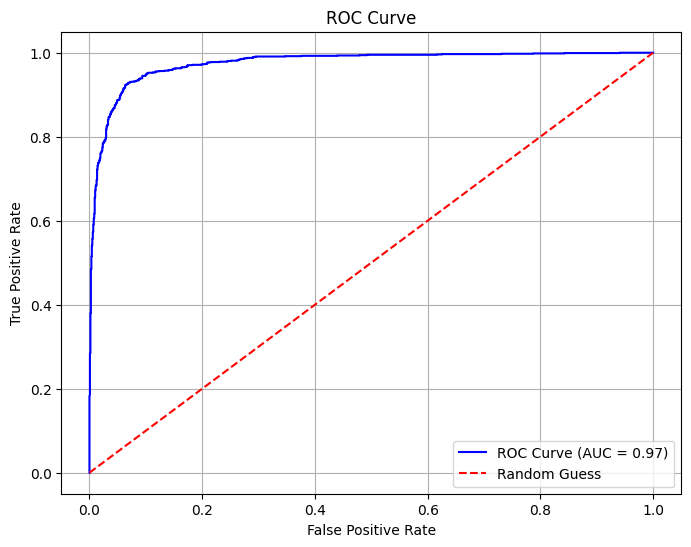

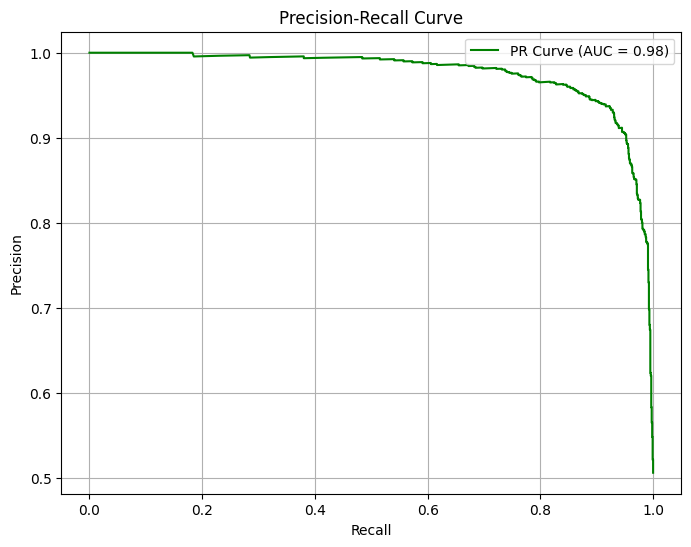

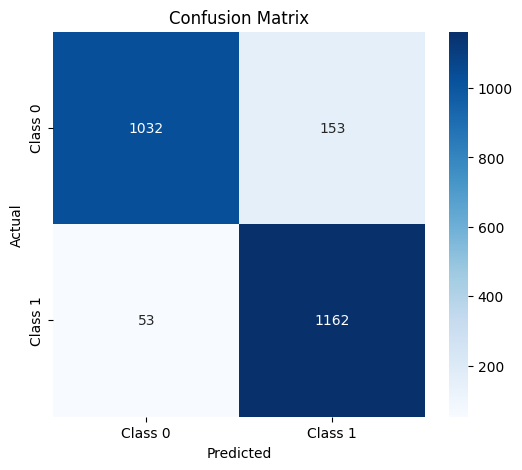

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.87      0.91      1185
           1       0.88      0.96      0.92      1215

    accuracy                           0.91      2400
   macro avg       0.92      0.91      0.91      2400
weighted avg       0.92      0.91      0.91      2400



In [30]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve, auc, confusion_matrix, classification_report
import seaborn as sns

# Evaluate the model with additional visualizations
def evaluate_model(model, test_loader, criterion):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)  # Move model to the right device
    model.eval()  # Set the model to evaluation mode

    running_test_loss = 0.0
    correct_test_preds = 0
    total_test_preds = 0

    all_labels = []
    all_preds = []
    all_probs = []  # To store probabilities for ROC and PR curves

    print("Evaluating the model...")
    with torch.no_grad():  # No need to track gradients during evaluation
        with tqdm(test_loader, unit="batch") as tepoch:  # Add progress bar
            for inputs, labels in tepoch:
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)
                running_test_loss += loss.item()

                # Get predicted class and probabilities
                probs = torch.softmax(outputs, dim=1)  # Softmax for probabilities
                _, predicted = torch.max(outputs, 1)
                
                all_probs.extend(probs.cpu().numpy()[:, 1])  # Assuming binary classification, take the probability of class 1
                all_preds.extend(predicted.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

                correct_test_preds += (predicted == labels).sum().item()
                total_test_preds += labels.size(0)

                # Update the progress bar description
                tepoch.set_postfix(loss=loss.item())

    avg_test_loss = running_test_loss / len(test_loader)
    test_accuracy = 100 * correct_test_preds / total_test_preds

    print(f"Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")

    # Convert all_labels and all_preds to numpy arrays for metrics
    all_labels = np.array(all_labels)
    all_preds = np.array(all_preds)
    all_probs = np.array(all_probs)

    # Call the visualization functions
    plot_roc_curve(all_labels, all_probs)
    plot_precision_recall_curve(all_labels, all_probs)
    plot_confusion_matrix(all_labels, all_preds)

    return avg_test_loss, test_accuracy

# Function to plot ROC Curve
def plot_roc_curve(labels, probs):
    fpr, tpr, _ = roc_curve(labels, probs)
    auc_score = roc_auc_score(labels, probs)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {auc_score:.2f})", color='b')
    plt.plot([0, 1], [0, 1], 'r--', label='Random Guess')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()
    plt.grid()
    plt.show()

# Function to plot Precision-Recall Curve
def plot_precision_recall_curve(labels, probs):
    precision, recall, _ = precision_recall_curve(labels, probs)
    pr_auc = auc(recall, precision)

    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, label=f"PR Curve (AUC = {pr_auc:.2f})", color='g')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend()
    plt.grid()
    plt.show()

# Function to plot Confusion Matrix
def plot_confusion_matrix(labels, preds):
    cm = confusion_matrix(labels, preds)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()
    
    # Print classification report
    print("Classification Report:")
    print(classification_report(labels, preds))

# Example usage (assuming model, test_loader, and criterion are already defined)
test_loss, test_accuracy = evaluate_model(model, test_loader, criterion)